In [ ]:
#Paquetes necesarios
pip install -r requirements.txt

In [259]:
#Paquetes necesarias para el preprocesamiento
import mne
from mne_bids import BIDSPath, read_raw_bids
import matplotlib.pyplot as plt
import pandas as pd 
import mne_connectivity
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
#Importar función de los autores
from technical_validation_utils import (get_raw_condition)
from config import bids_root

In [ ]:
%matplotlib widget

In [5]:
#Preprocesamiento de datos crudos (Saltar- Toma alrededor de 25 minutos)
#Mano izquierda

session = 'PeriOp'

datatype = 'meg'

subjects = ['0cGdk9', '2IU8mi', 'AB2PeX', 'AbzsOg', 
            'dCsWjQ', 'FYbcap', 'gNX5yb', 'hnetKS', 'i4oK0F','oLNpHd', 'PuPVlx', 'QZTsn6']

acquisitions = ['MedOff', 'MedOn']

tasks = ['MoveL', 'HoldL']

run = '1'

Med_Off_rest_arr = []
Med_On_rest_arr = []
Med_Off_rest_df = []
Med_On_rest_df = []
Med_Off_MoveL_arr = []
Med_Off_MoveL_df = []
Med_Off_HoldL_arr = []
Med_Off_HoldL_df = []
Med_On_MoveL_arr = []
Med_On_MoveL_df = []
Med_On_HoldL_arr = []
Med_On_HoldL_df = []

coords_saved = False

def sort_channels(ch_list):
    return sorted(ch_list, key=lambda x: (x.split('-')[0], int(x.split('-')[1])))

for subject in subjects:
    for acquisition in acquisitions:
        for task in tasks:

            # Detectar automáticamente si existen archivos spliteados
            search_base = BIDSPath(
                root=bids_root,
                session=session,
                subject=subject,
                datatype=datatype,
                task=task,
                acquisition=acquisition,
                run=run,
                suffix='meg'
            )
            
            # Buscar archivos split
            matches = search_base.match()
            # Si no hay archivos para esta combinación, saltar
            if len(matches) == 0:
                continue

            # Si hay splits (01, 02, ...)
            split_files = [m for m in matches if 'split' in m.basename]
            
            if len(split_files) > 0:
                # usar split=01 (MNE carga automáticamente split-02 también)
                bids_path = search_base.copy().update(split='01')
            else:
                # no usar split
                bids_path = search_base.copy()
            
            raw = read_raw_bids(bids_path)


            # Escoger los tipos de canales deseados. EEG = LFP
            channel_to_pick = {'meg':'grad', 'eeg': True, 'emg': False, 'eog': False, 'stim': False}
            
            # Escoger todos los canales y excluir los malos
            raw.pick_types(**channel_to_pick, exclude=[])
            
            # Cargar datos
            raw.load_data()

            # Renombrar canales MEG y EEG (LFP)
            for i, ch in enumerate(raw.ch_names):
                if ch.startswith('MEG'):
                    raw.rename_channels({ch: f"MEG-{i}"})
                elif raw.get_channel_types(picks=ch)[0] == 'eeg':
                    raw.rename_channels({ch: f"LFP-{i}"})
            
            # apply a 1Hz high pass firwin filter to remove slow drifts
            raw.filter(l_freq=1, h_freq=None, method='fir', n_jobs=-1)
            
            # after filtering, now do downsample to 200 from 2000. NB: downsample after filter so no aliasing introduced
            raw.resample(200)
            
            # prepare the conditions to crop the data and get the rest_segments and task_segments
            conditions = ['rest'] + [bids_path.task] # rest + task (hold or move)
            rest_segments, task_segments = get_raw_condition(raw, conditions)
            segments = [("rest", rest_segments), ("task", task_segments)]

            # Igualar canales entre condiciones para evitar matrices no cuadradas
            # Manejo seguro por si algún segmento no existe
            if rest_segments is None or task_segments is None:
                if rest_segments is None and task_segments is None:
                    continue
                else:
                    # Si solo existe uno, usamos sus canales directamente
                    if rest_segments is None:
                        common_chs = list(task_segments.ch_names)
                        task_segments.pick_channels(common_chs)
                    else:
                        common_chs = list(rest_segments.ch_names)
                        rest_segments.pick_channels(common_chs)
            else:
                # Ambos segmentos existen → usar intersección
                common_chs = list(set(rest_segments.ch_names).intersection(task_segments.ch_names))
                rest_segments.pick_channels(common_chs)
                task_segments.pick_channels(common_chs)

#GUARDAR COORDENADAS
            # ================================
            if not coords_saved:
                coords_dict = {}
                for ch in raw.info['chs']:
                    name = ch['ch_name']
                    x, y, z = ch['loc'][:3]
                    coords_dict[name] = [float(x), float(y), float(z)]

                import json, csv

                with open("channel_coords.json", "w") as f:
                    json.dump(coords_dict, f, indent=4)

                with open("channel_coords.csv", "w", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow(["channel", "x", "y", "z"])
                    for ch, (x, y, z) in coords_dict.items():
                        writer.writerow([ch, x, y, z])

                coords_saved = True
            # ================================

            for seg_name, segment in segments:
                # from now on we will focus only in the resting state segment we just cropped
                # create epochs of fixed length 2 seconds and 50% overlap.
                epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)
                
                # get the epochs data to compute connectivity
                data = epochs.get_data(copy=True)

                #Data está en la forma (n_epochs,n_nodos,n_puntos por epoch (sampling freq * duración epoch)), se reordena el array para que cada fila
                #sea cada nodo y se colapsa a dos dimensiones para que en lugar estar cortando por cada epoch se obtenga una serie continua de todos
                #los puntos en el tiempo de cada canal. Esto tendría la forma n_nodos, n_epochs*n_puntos por epoch. Así ya es posible graficar
                #y correlacionar.

                n_epochs, n_channels, n_times = data.shape
                # Si no se crearon epochs, saltar
                if n_epochs == 0:
                    continue

                # Concatenamos todos los epochs en el eje del tiempo
                # Concatenación segura de epochs en el eje temporal
                data_concat = np.concatenate([data[e] for e in range(n_epochs)], axis=1)
                corr_matrix = np.corrcoef(data_concat)
                sz = list(epochs.ch_names)
                
                # ORDENAR CANALES Y REORDENAR MATRIZ
                # -----------------------------------------
                ordered_chs = sort_channels(sz)
                corr_matrix_ordered = corr_matrix[np.ix_(
                    [sz.index(ch) for ch in ordered_chs],
                    [sz.index(ch) for ch in ordered_chs]
                )]

                corr_df = pd.DataFrame(data=corr_matrix_ordered,
                                       index=ordered_chs,
                                       columns=ordered_chs)

                # Guardado según condición
                if acquisition == 'MedOff' and seg_name == 'rest':
                    Med_Off_rest_arr.append(corr_matrix_ordered)
                    Med_Off_rest_df.append(corr_df)

                if acquisition == 'MedOn' and seg_name == 'rest':
                    Med_On_rest_arr.append(corr_matrix_ordered)
                    Med_On_rest_df.append(corr_df)

                if acquisition == 'MedOff' and seg_name == 'task' and task == 'MoveL':
                    Med_Off_MoveL_arr.append(corr_matrix_ordered)
                    Med_Off_MoveL_df.append(corr_df)

                if acquisition == 'MedOff' and seg_name == 'task' and task == 'HoldL':
                    Med_Off_HoldL_arr.append(corr_matrix_ordered)
                    Med_Off_HoldL_df.append(corr_df)

                if acquisition == 'MedOn' and seg_name == 'task' and task == 'MoveL':
                    Med_On_MoveL_arr.append(corr_matrix_ordered)
                    Med_On_MoveL_df.append(corr_df)

                if acquisition == 'MedOn' and seg_name == 'task' and task == 'HoldL':
                    Med_On_HoldL_arr.append(corr_matrix_ordered)
                    Med_On_HoldL_df.append(corr_df)
                
                key_df = f"corr_df_{subject}_{acquisition}_{task}_{seg_name}"
                corr_df.to_csv(f"{key_df}.csv")

Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-MoveL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 114000 ... 1355999 =     57.000 ...   678.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-MoveL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
298 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 298 events and 400 original time points ...
11 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
310 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 310 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 124500 ... 1597499 =     62.250 ...   798.750 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
3 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
338 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 338 events and 400 original time points ...
12 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 75000 ... 1175999 =     37.500 ...   588.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    5.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
238 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 238 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
204 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 204 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-HoldL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 219000 ... 1538999 =    109.500 ...   769.500 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\sub-0cGdk9_ses-PeriOp_task-HoldL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-0cGdk9\ses-PeriOp\meg\su

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.8s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
238 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 238 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
315 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 315 events and 400 original time points ...
17 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-MoveL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 42000 ... 1562999 =     21.000 ...   781.500 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-MoveL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\s

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.9s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
309 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 309 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 2862000 ... 4336499 =   1431.000 ...  2168.249 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
319 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 319 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 39000 ... 1570499 =     19.500 ...   785.250 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.5s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
338 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 338 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 106500 ... 1760999 =     53.250 ...   880.500 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-2IU8mi\ses-PeriOp\meg\sub-2IU8mi_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-02_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
      

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
392 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 392 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


10 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 189000 ... 1843499 =     94.500 ...   921.750 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-02_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [14]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    9.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
7 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
433 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 433 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


12 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1722000 ... 3358499 =    861.000 ...  1679.249 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [14]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.9s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
285 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 285 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
398 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 398 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


8 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 84000 ... 1685999 =     42.000 ...   843.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2P

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [14]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.5s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
249 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 249 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
413 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 413 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


8 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-HoldL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 340500 ... 1927499 =    170.250 ...   963.750 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2PeX\ses-PeriOp\meg\sub-AB2PeX_ses-PeriOp_task-HoldL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AB2

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [14]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.5s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
22 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
367 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 367 events and 400 original time points ...
30 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AbzsOg\ses-PeriOp\meg\sub-AbzsOg_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 88500 ... 1738499 =     44.250 ...   869.250 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AbzsOg\ses-PeriOp\meg\sub-AbzsOg_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-02_meg.fif...
    Read a total of 9 projection items:
    

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    9.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
9 bad epochs dropped
Not setting metadata
392 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 392 events and 400 original time points ...
8 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AbzsOg\ses-PeriOp\meg\sub-AbzsOg_ses-PeriOp_task-HoldL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.8s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped
Not setting metadata
462 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 462 events and 400 original time points ...
6 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AbzsOg\ses-PeriOp\meg\sub-AbzsOg_ses-PeriOp_task-MoveL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:   10.6s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped
Not setting metadata
397 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 397 events and 400 original time points ...
10 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-AbzsOg\ses-PeriOp\meg\sub-AbzsOg_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [10]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.7s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped
Not setting metadata
438 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 438 events and 400 original time points ...
6 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg\sub-dCsWjQ_ses-PeriOp_task-MoveL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.6s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
10 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
350 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 350 events and 400 original time points ...
17 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg\sub-dCsWjQ_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1456500 ... 3016499 =    728.250 ...  1508.249 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg\sub-dCsWjQ_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.6s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
293 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 293 events and 400 original time points ...
9 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
400 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 400 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


6 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg\sub-dCsWjQ_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 376500 ... 1925999 =    188.250 ...   963.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg\sub-dCsWjQ_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCs

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
333 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 333 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg\sub-dCsWjQ_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 436500 ... 2090999 =    218.250 ...  1045.499 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-dCsWjQ\ses-PeriOp\meg\sub-dCsWjQ_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-02_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
      

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.7s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
419 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 419 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 200/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


12 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-MoveL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 136500 ... 1580999 =     68.250 ...   790.500 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-MoveL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [8]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.6s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
312 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 312 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1284000 ... 2741999 =    642.000 ...  1370.999 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [8]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.9s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
330 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 330 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 129000 ... 1592999 =     64.500 ...   796.500 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\su

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [8]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.9s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
4 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
314 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 314 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-HoldL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 220500 ... 1625999 =    110.250 ...   813.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\sub-FYbcap_ses-PeriOp_task-HoldL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-FYbcap\ses-PeriOp\meg\su

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [8]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.5s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
7 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
310 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 310 events and 400 original time points ...
15 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 105000 ... 1759499 =     52.500 ...   879.750 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-02_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
    

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [15]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    9.9s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
462 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 462 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


12 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1338000 ... 2914499 =    669.000 ...  1457.249 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [15]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.0s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
4 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
472 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 472 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


0 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-MoveL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 301500 ... 1955999 =    150.750 ...   978.000 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-MoveL_acq-MedOn_run-1_split-02_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [15]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
5 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
373 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 373 events and 400 original time points ...
12 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-HoldL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 394500 ... 1973999 =    197.250 ...   987.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\sub-gNX5yb_ses-PeriOp_task-HoldL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-gNX5yb\ses-PeriOp\meg\su

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [15]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
432 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 432 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


17 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-MoveL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 502500 ... 1961999 =    251.250 ...   981.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-MoveL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [21]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
7 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
315 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 315 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1299000 ... 2771999 =    649.500 ...  1385.999 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [21]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.0s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
11 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
328 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 328 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 319500 ... 1774499 =    159.750 ...   887.250 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\su

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [21]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.0s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
319 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 319 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-HoldL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1428000 ... 2876999 =    714.000 ...  1438.499 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\sub-hnetKS_ses-PeriOp_task-HoldL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-hnetKS\ses-PeriOp\meg\s

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [21]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.9s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
14 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
335 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 335 events and 400 original time points ...
18 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-MoveL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 79500 ... 1589999 =     39.750 ...   795.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-MoveL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\s

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [1]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
12 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
324 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 324 events and 400 original time points ...
34 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 2080500 ... 3631499 =   1040.250 ...  1815.749 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [1]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
5 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
345 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 345 events and 400 original time points ...
28 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 66000 ... 1507499 =     33.000 ...   753.750 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [1]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.7s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
318 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 318 events and 400 original time points ...
6 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-HoldL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1038000 ... 2579999 =    519.000 ...  1289.999 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\sub-i4oK0F_ses-PeriOp_task-HoldL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-i4oK0F\ses-PeriOp\meg\s

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [1]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.6s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
14 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
339 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 339 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-oLNpHd\ses-PeriOp\meg\sub-oLNpHd_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 177000 ... 1831499 =     88.500 ...   915.750 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-oLNpHd\ses-PeriOp\meg\sub-oLNpHd_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-02_meg.fif...
    Read a total of 9 projection items:
   

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [12]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:   10.5s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped
Not setting metadata
491 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 491 events and 400 original time points ...
14 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-oLNpHd\ses-PeriOp\meg\sub-oLNpHd_ses-PeriOp_task-HoldL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idl

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [12]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:   10.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped
Not setting metadata
599 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 599 events and 400 original time points ...
12 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-oLNpHd\ses-PeriOp\meg\sub-oLNpHd_ses-PeriOp_task-MoveL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [12]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.5s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
233 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 233 events and 400 original time points ...
2 bad epochs dropped
Not setting metadata
347 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 347 events and 400 original time points ...
62 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-oLNpHd\ses-PeriOp\meg\sub-oLNpHd_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 9 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [12]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.7s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
8 bad epochs dropped
Not setting metadata
378 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
9 projection items activated
Using data from preloaded Raw for 378 events and 400 original time points ...
49 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\sub-PuPVlx_ses-PeriOp_task-MoveL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idl

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    9.8s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
503 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 503 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


6 bad epochs dropped
Not setting metadata
341 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 341 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\sub-PuPVlx_ses-PeriOp_task-HoldL_acq-MedOff_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 1878000 ... 3532499 =    939.000 ...  1766.249 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\sub-PuPVlx_ses-PeriOp_task-HoldL_acq-MedOff_run-1_split-02_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
   

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
316 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 316 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
331 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 331 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\sub-PuPVlx_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 138000 ... 1781999 =     69.000 ...   891.000 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\sub-PuPVlx_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\su

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.6s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
357 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 357 events and 400 original time points ...
20 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
331 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 331 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\sub-PuPVlx_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-01_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 417000 ... 2071499 =    208.500 ...  1035.749 secs
Ready.
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-PuPVlx\ses-PeriOp\meg\sub-PuPVlx_ses-PeriOp_task-HoldL_acq-MedOn_run-1_split-02_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
      

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [6]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
5 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
429 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 429 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


23 bad epochs dropped
Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-MoveL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 45000 ... 1489499 =     22.500 ...   744.750 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-MoveL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-Q

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [17]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
5 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
308 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 308 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-HoldL_acq-MedOff_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 2619000 ... 4102499 =   1309.500 ...  2051.249 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-HoldL_acq-MedOff_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [17]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
7 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
320 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 320 events and 400 original time points ...
8 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-MoveL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 49500 ... 1531499 =     24.750 ...   765.750 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-MoveL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [17]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    7.0s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
299 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 299 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
353 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 353 events and 400 original time points ...
6 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Opening raw data file C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-HoldL_acq-MedOn_run-1_meg.fif...
    Read a total of 8 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
    Range : 211500 ... 1681499 =    105.750 ...   840.750 secs
Ready.
Reading events from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\sub-QZTsn6_ses-PeriOp_task-HoldL_acq-MedOn_run-1_events.tsv.
Reading channel info from C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\Data\sub-QZTsn6\ses-PeriOp\meg\su

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:66: RuntimeWarning: Unable to map the following column(s) to to MNE:
hand (subject handedness): unknown
disease: ['Parkinson Disease']
diseaseDuration: [17]
  raw = read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.9s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
280 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 280 events and 400 original time points ...
0 bad epochs dropped


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


Not setting metadata
392 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
8 projection items activated
Using data from preloaded Raw for 392 events and 400 original time points ...


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2693331951.py:141: RuntimeWarning: Projection vector 'grad_ssp_upright.fif : PCA-v1' has been reduced to 0.01% of its original magnitude by subselecting 202/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  epochs = mne.make_fixed_length_epochs(segment, duration=2, overlap=1, preload=True)


6 bad epochs dropped


In [11]:
#Coordenadas
coords = pd.read_csv(r"C:\Users\PC\Desktop\Neurociencias\Modelos Computacionales I\channel_coords.csv")
coords.set_index('channel', drop=True, inplace=True)
coords

x       y       z
channel                        
MEG-0   -0.1066  0.0464 -0.0604
MEG-1   -0.1066  0.0464 -0.0604
MEG-2   -0.1020  0.0631 -0.0256
MEG-3   -0.1020  0.0631 -0.0256
MEG-4   -0.1085  0.0302 -0.0266
...         ...     ...     ...
LFP-207  0.0000  0.0000  0.0000
LFP-208  0.0000  0.0000  0.0000
LFP-209  0.0000  0.0000  0.0000
LFP-210  0.0000  0.0000  0.0000
LFP-211  0.0000  0.0000  0.0000

[212 rows x 3 columns]

## Comparación Reposo - Tarea

In [133]:
def estadisticos_df2(lista_dfs):

    todo, p25,p50,p75,p90,p95,promedio = [],[],[],[],[],[],[],
    
    fig, axes = plt.subplots(2,2, figsize=(12,7))
    for sujetos in lista_dfs:
        data = sujetos.stack().values
        #Estadísticos
        todo.append(sujetos.stack().values)
        p25.append(np.percentile(data,25))
        p50.append(np.percentile(data,50))
        p75.append(np.percentile(data,75))
        p90.append(np.percentile(data,90))
        p95.append(np.percentile(data,95))
        promedio.append(np.mean(data))
        sns.histplot(sujetos.stack().values,ax=axes[0][0], kde=True)
        sns.ecdfplot(sujetos.stack().values,ax=axes[0][1])
    todo_final = np.concatenate(todo)

        # Plots
        
    axes[1][0].plot(p25,label = 'Percentil al 25%')
    axes[1][0].plot(p50,label = 'Percentil al 50%')
    axes[1][0].plot(p75,label = 'Percentil al 75%')
    axes[1][0].plot(p90,label = 'Percentil al 90%')
    axes[1][0].plot(p95,label = 'Percentil al 95%')
    axes[1][0].plot(promedio,label = 'Promedio')
    axes[1][0].legend()

    estadisticos = pd.DataFrame(index = ['Valor','Min','Max','Media','mediana','p30','p75','Normalidad'], 
                            columns = ['p25','p50','p75','p90','p95','Media'])
    lista = [p25,p50,p75,p90,p95,promedio]
    lista2 = ['p25','p50','p75','p90','p95','Media']
    for estadistico,nombre in zip(lista,lista2):
        minn, maxx, mean, p30, p75_, median,  = min(estadistico), max(estadistico), np.mean(estadistico), np.percentile(estadistico,30), np.percentile(estadistico,75), np.median(estadistico)
        shapiro_statistic, shapiro_pvalue = stats.shapiro(estadistico)
        if nombre == 'p25':
            valor = np.percentile(todo_final,25)
        elif nombre == 'p50':
            valor = np.percentile(todo_final,50)
        elif nombre == 'p75':
            valor = np.percentile(todo_final,75)
        elif nombre == 'Media':
            valor = np.mean(todo_final)
        elif nombre == 'p90':
            valor = np.percentile(todo_final,90)
        elif nombre == 'p95':
            valor = np.percentile(todo_final,95)
        if shapiro_pvalue>=0.05:
            valores = [valor,minn, maxx, mean, median, p30, p75_,'Sí']
        else:
            valores = [valor,minn, maxx, mean, median, p30, p75_,'No']
        estadisticos[nombre] = valores
    estadisticos = estadisticos.round(4)
    estadisticos = estadisticos.applymap(lambda x: f"{x:.5f}" if isinstance(x,(float,int)) else x)
    axes[1][1].axis('off')  # desactiva los ejes
    tabla = axes[1][1].table(
        cellText=estadisticos.values,
        rowLabels=estadisticos.index,
        colLabels=estadisticos.columns,
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(7)
    tabla.scale(0.9, 0.9)

    return

In [38]:
#Obtener matriz de valores negativos
def capsulaneg(lista_dfs, umbral, porcentaje):
    stack = np.stack([df.values for df in lista_dfs])
    
    #Filtro a cada matriz
    above = stack<umbral
    
    N = len(lista_dfs)
    count_above = above.sum(axis = 0) #Contar cuantos valores de cada matriz supera el umbral
    minimo = int(np.ceil(porcentaje*N))
    
    result_bool = count_above >= minimo
    result_df = pd.DataFrame(result_bool, index=lista_dfs[0].index,
                            columns = lista_dfs[0].columns).astype(int)
    return result_df

In [329]:
#Función métricas (Corregida para usar el componente más grande conectado en caso de que el grafo no se conecte todo)
def metricas(df_final):
    G = nx.from_pandas_adjacency(df_final)

    # --- Manejar grafo desconectado ---
    if not nx.is_connected(G):
        # identificar componente gigante
        comp_gigante = max(nx.connected_components(G), key=len)
        Gc = G.subgraph(comp_gigante).copy()
    else:
        Gc = G
    
    # --- Métricas ---
    clust_coeff = nx.average_clustering(Gc)

    try:
        path_length = nx.average_shortest_path_length(Gc)
    except nx.NetworkXError:
        path_length = np.nan

    # Mundo pequeño
    G_rand = nx.gnm_random_graph(n=Gc.number_of_nodes(), m=Gc.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)

    # Modularidad
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(Gc)
    comunidades_multiples = [c for c in communities if len(c) > 1]
    comunidades_unicas = [c for c in communities if len(c) == 1]
    modularity = community.modularity(Gc, communities)

    # Hubs
    degree_dict = dict(Gc.degree())
    top3 = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:3]
    betwenness = nx.betweenness_centrality(Gc)
    betwenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)

    global_eff = nx.global_efficiency(Gc)
    local_eff = nx.local_efficiency(Gc)

    # DataFrame
    lista_c = ['CC','Camino más corto','Sigma','Comms >1','Comms 1',
               'Mod','Cent','Ef. global','Ef. local','Top 3 hubs']
    valores_m = [clust_coeff, path_length, small_world_sigma, 
                 len(comunidades_multiples), len(comunidades_unicas),
                 modularity, betwenness[0], global_eff, local_eff, top3]

    metricas_df = pd.DataFrame(columns=lista_c)
    metricas_df.loc[0, :] = valores_m

    return (metricas_df, communities, betwenness, degree_dict)

In [ ]:
from modulo import *

In [ ]:
#Plotear lado a lado matriz de correlaciones positivas y negativas
def Mat_pos_neg(lista_dfs):
    pos = capsula(lista_dfs, 0, 1)
    neg = capsulaneg(lista_dfs, 0, 1)
    fig = plt.figure(figsize=(12,4.5))
    axes = [fig.add_subplot(1, 2, 1),
            fig.add_subplot(1, 2, 2)]
    sns.heatmap(pos, ax=axes[0])
    sns.heatmap(neg, ax=axes[1])

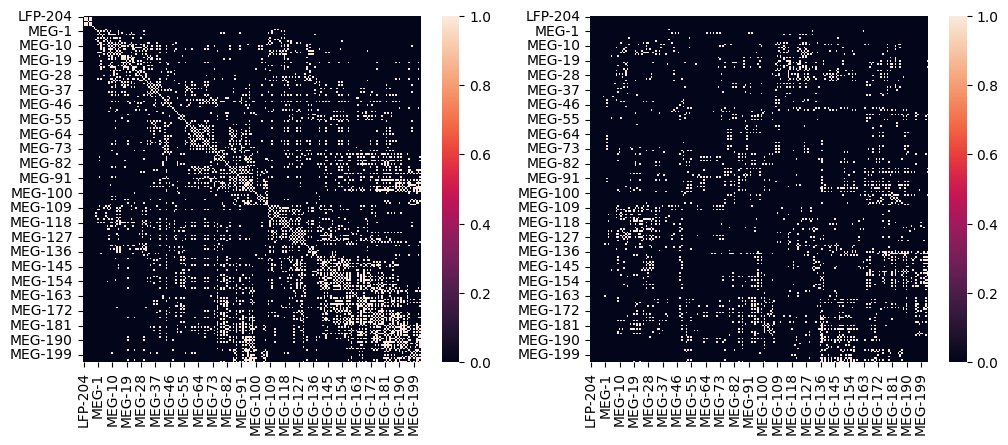

In [105]:
Mat_pos_neg(Med_Off_rest_df)

In [ ]:
#Sacar matriz positiva o negativa a cada matriz y hacer una lista de ellas
def mascara(lista_matrices,signo):
    resultado = []
    for M in lista_matrices:
        arr = M.values if hasattr(M, "values") else M
        if signo == 'positivo':
            filtrada = np.where(arr > 0, arr, 0)
        elif signo == 'negativo':
            filtrada = np.where(arr < 0, arr, 0)
        if hasattr(M, "values"):  # si era DataFrame
            filtrada = pd.DataFrame(filtrada, index=M.index, columns=M.columns)
        resultado.append(filtrada)
    return resultado

In [ ]:
Med_Off_rest_neg = mascara(Med_Off_rest_df,'negativo')
Med_Off_rest_pos = mascara(Med_Off_rest_df,'positivo')

estadisticos_df2(Med_Off_rest_neg) 
#Viendo la distribución de los datos de la matriz negativa, además de su mapa de calor
#no se observa la presencia de comunidades ni conexiones con altos niveles de anti-correlación. Por esta razón, no se seguirá
#con esta matriz.

C:\Users\PC\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\139373287.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estadisticos = estadisticos.applymap(lambda x: f"{x:.5f}" if isinstance(x,(float,int)) else x)


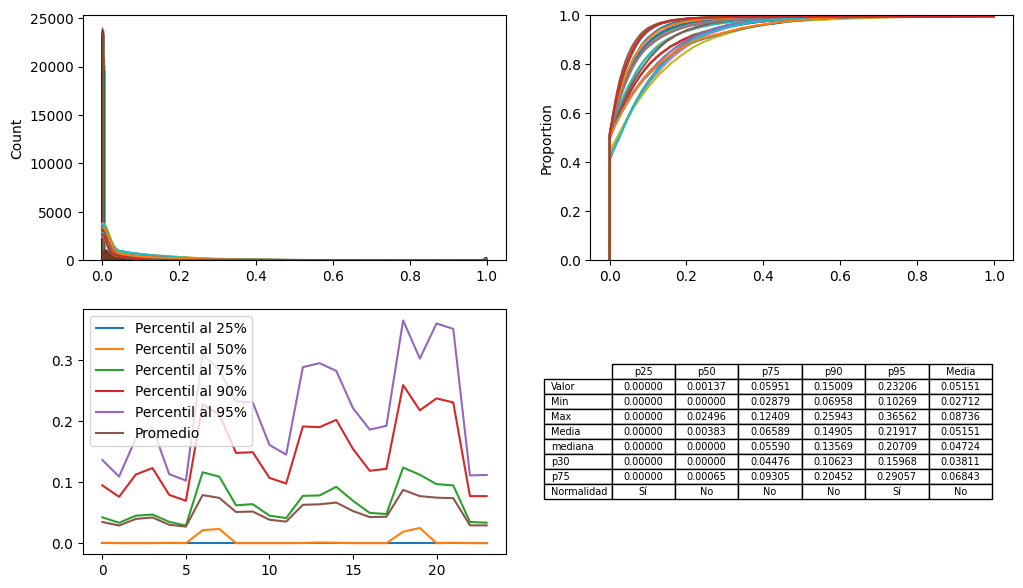

In [135]:
estadisticos_df2(Med_Off_rest_pos)

In [ ]:
#Umbralizar primero cada matriz (lista_dfs, umbral)
def mat_por_mat(lista_dfs, umbral):
    result_dfs = []
    for matriz in lista_dfs:
        val = matriz.values
        a = np.percentile(val,umbral)
        m_filtrada = np.where(val > a, 1, 0)
        m_filtrada = pd.DataFrame(m_filtrada, index=matriz.index, columns=matriz.columns)
        result_dfs.append(m_filtrada)
    return result_dfs

<Axes: >

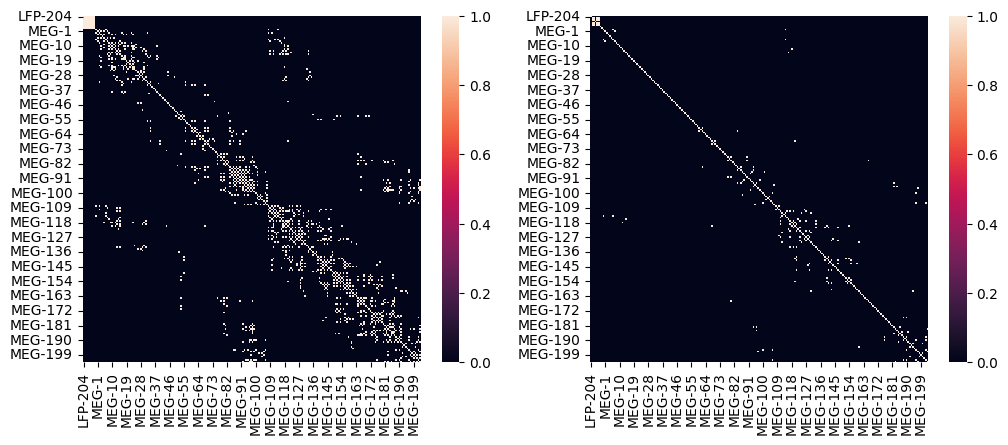

In [139]:
#Observando la distribución de los valores, se optó por probar dos opciones de umbral: 1.- Binarizar cada matriz según su p95
# y después obtener la matriz final con un consenso de 51%; y 2.- Umbral absoluto de la media del percentil 95.
result_dfs_Med_Med_Off_rest = mat_por_mat(Med_Off_rest_pos,95)
democracia_Med_Off_rest = capsula(result_dfs,0.9,0.51)
monarquia_Med_Off_rest = capsula(Med_Off_rest_pos,0.15,1)
fig = plt.figure(figsize=(12,4.5))
axes = [fig.add_subplot(1, 2, 1),
            fig.add_subplot(1, 2, 2)]
sns.heatmap(democracia, ax=axes[0])
sns.heatmap(monarquia, ax=axes[1])

In [ ]:
#El método que mejor preserva la información claramente es el 1. Este se eligió porque umbralizar cada matriz toma en cuenta
#la variabilidad inter-sujeto, haciendo que cada uno aporte su top 5% de conexiones más fuertes, a la vez que busca un consenso
#de este 5% de conexiones a lo largo de todos ellos. Este método preserva las conexiones más singificativas de y entre cada sujeto
#a diferencia del método 2 que, por la variabilidad intrínseca (por más que el p95 siga una distribución normal), pierde mucha información.

#El mismo análisis se aplica para la condición medicada

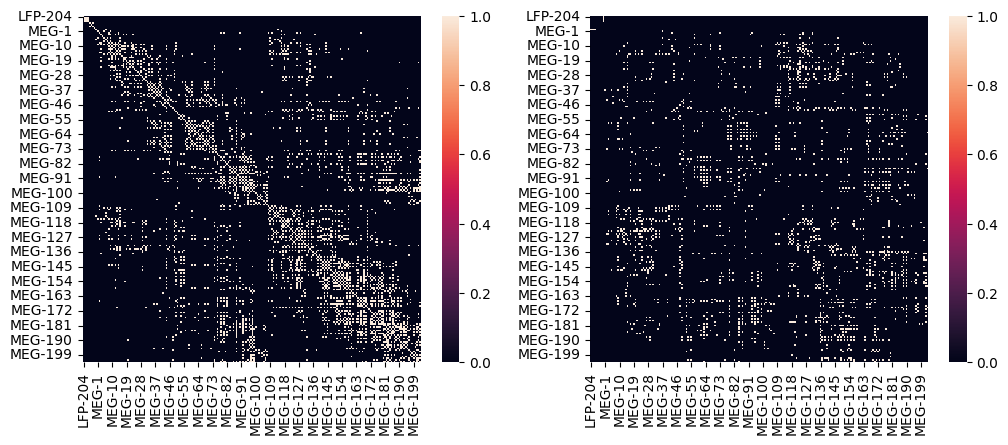

In [126]:
Mat_pos_neg(Med_On_rest_df)

In [141]:
Med_On_rest_pos = mascara(Med_On_rest_df,'positivo')

C:\Users\PC\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\139373287.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estadisticos = estadisticos.applymap(lambda x: f"{x:.5f}" if isinstance(x,(float,int)) else x)


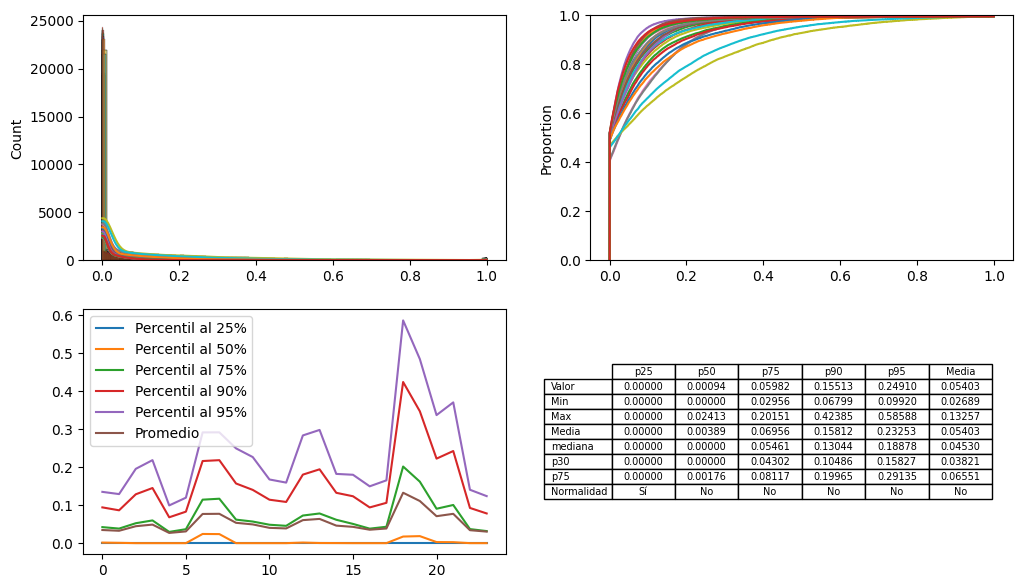

In [142]:
estadisticos_df2(Med_On_rest_pos)

In [138]:
#Viendo las similitud entre los estadísticos de la condición de MedOn y MedOff, se aplica el mismo criterio de umbralización.

Text(0.5, 1.0, 'Med_On rest')

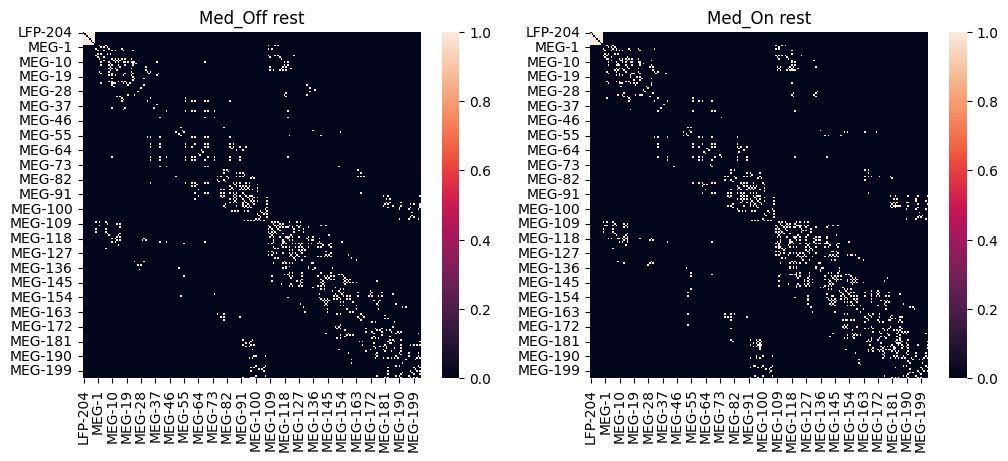

In [354]:
result_dfs_Med_Med_Off_rest = mat_por_mat(Med_Off_rest_pos,95)
democracia_Med_Off_rest = capsula(result_dfs_Med_Med_Off_rest,0.9,0.51)
result_dfs_Med_Med_On_rest = mat_por_mat(Med_On_rest_pos,95)
democracia_Med_On_rest = capsula(result_dfs_Med_Med_On_rest,0.9,0.51)

fig = plt.figure(figsize=(12,4.5))
axes = [fig.add_subplot(1, 2, 1),
            fig.add_subplot(1, 2, 2)]

#Eliminar diagonal
democracia_Med_Off_rest = democracia_Med_Off_rest - np.eye(212)
democracia_Med_On_rest = democracia_Med_On_rest - np.eye(212)

sns.heatmap(democracia_Med_Off_rest, ax=axes[0])
sns.heatmap(democracia_Med_On_rest, ax=axes[1])
axes[0].set_title('Med_Off rest')
axes[1].set_title('Med_On rest')

In [245]:
#Función grafo 3D con tamaño de nodos según grado y resaltando Hub
def graf3dHub(df, coord_df, ax):
    G = nx.from_pandas_adjacency(df)
    
    degree_dict = dict(G.degree())
    df_grados = pd.DataFrame(columns=['Nodo', 'Grado'])

    for i, nodo in enumerate(degree_dict.keys()):
        df_grados.loc[i, 'Nodo'] = nodo
        df_grados.loc[i, 'Grado'] = degree_dict[nodo]

    pos3D = {nodo: (coord_df.loc[nodo, 'x'],
                    coord_df.loc[nodo, 'y'],
                    coord_df.loc[nodo, 'z']) for nodo in coord_df.index}
    
    df_grados = df_grados.sort_values('Grado', ascending=False)
    hub = df_grados.iloc[0]['Nodo']

    for nodo, (x, y, z) in pos3D.items():
        tamaño = degree_dict[nodo] * 55
        
        if nodo == hub:
            ax.scatter(x, y, z, s=tamaño*2, c='red')
        else:
            ax.scatter(x, y, z, s=tamaño, c='#4290bd')

    
    for i, j, data in G.edges(data=True):
        x = [pos3D[i][0], pos3D[j][0]]
        y = [pos3D[i][1], pos3D[j][1]]
        z = [pos3D[i][2], pos3D[j][2]]
        ax.plot(x, y, z, c='black')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Red de conectividad 3D')

In [246]:
#Función grafo 2D con coordenadas
def graf2d(df_final, coords, ax):
    G = nx.from_pandas_adjacency(df_final)
    pos2d = {
    nodo: (coords.loc[nodo].iloc[0], coords.loc[nodo].iloc[1])
    for nodo in coords.index
}
    nx.draw(
        G,
        pos=pos2d,
        with_labels=False,
        node_size=75,
        ax=ax
    )

In [338]:
#Métricas de ambas condiciones:
(metricas_Med_Off_rest, communities_MOffR, betwenness_MOffR, degree_dict_MOffR) = metricas(democracia_Med_Off_rest)
metricas_Med_Off_rest.index = ['MedOff Rest']
metricas_Med_Off_rest

CC Camino más corto     Sigma Comms >1 Comms 1       Mod  \
MedOff Rest  0.473553         4.767531  6.093139        8       0  0.586862   

                                       Cent Ef. global Ef. local  \
MedOff Rest  (MEG-120, 0.20996780127217704)   0.268393  0.633108   

                                              Top 3 hubs  
MedOff Rest  [(MEG-92, 15), (MEG-98, 15), (MEG-117, 14)]

In [339]:
(metricas_Med_On_rest, communities_MOnR, betwenness_MOnR, degree_dict_MOnR) = metricas(democracia_Med_On_rest)
metricas_Med_On_rest.index = ['MedOn Rest']
metricas_Med_On_rest

CC Camino más corto    Sigma Comms >1 Comms 1       Mod  \
MedOn Rest  0.469175         4.748389  6.81097        7       0  0.629023   

                                      Cent Ef. global Ef. local  \
MedOn Rest  (MEG-110, 0.21083627249700357)   0.271594  0.618466   

                                               Top 3 hubs  
MedOn Rest  [(MEG-110, 18), (MEG-121, 15), (MEG-153, 15)]

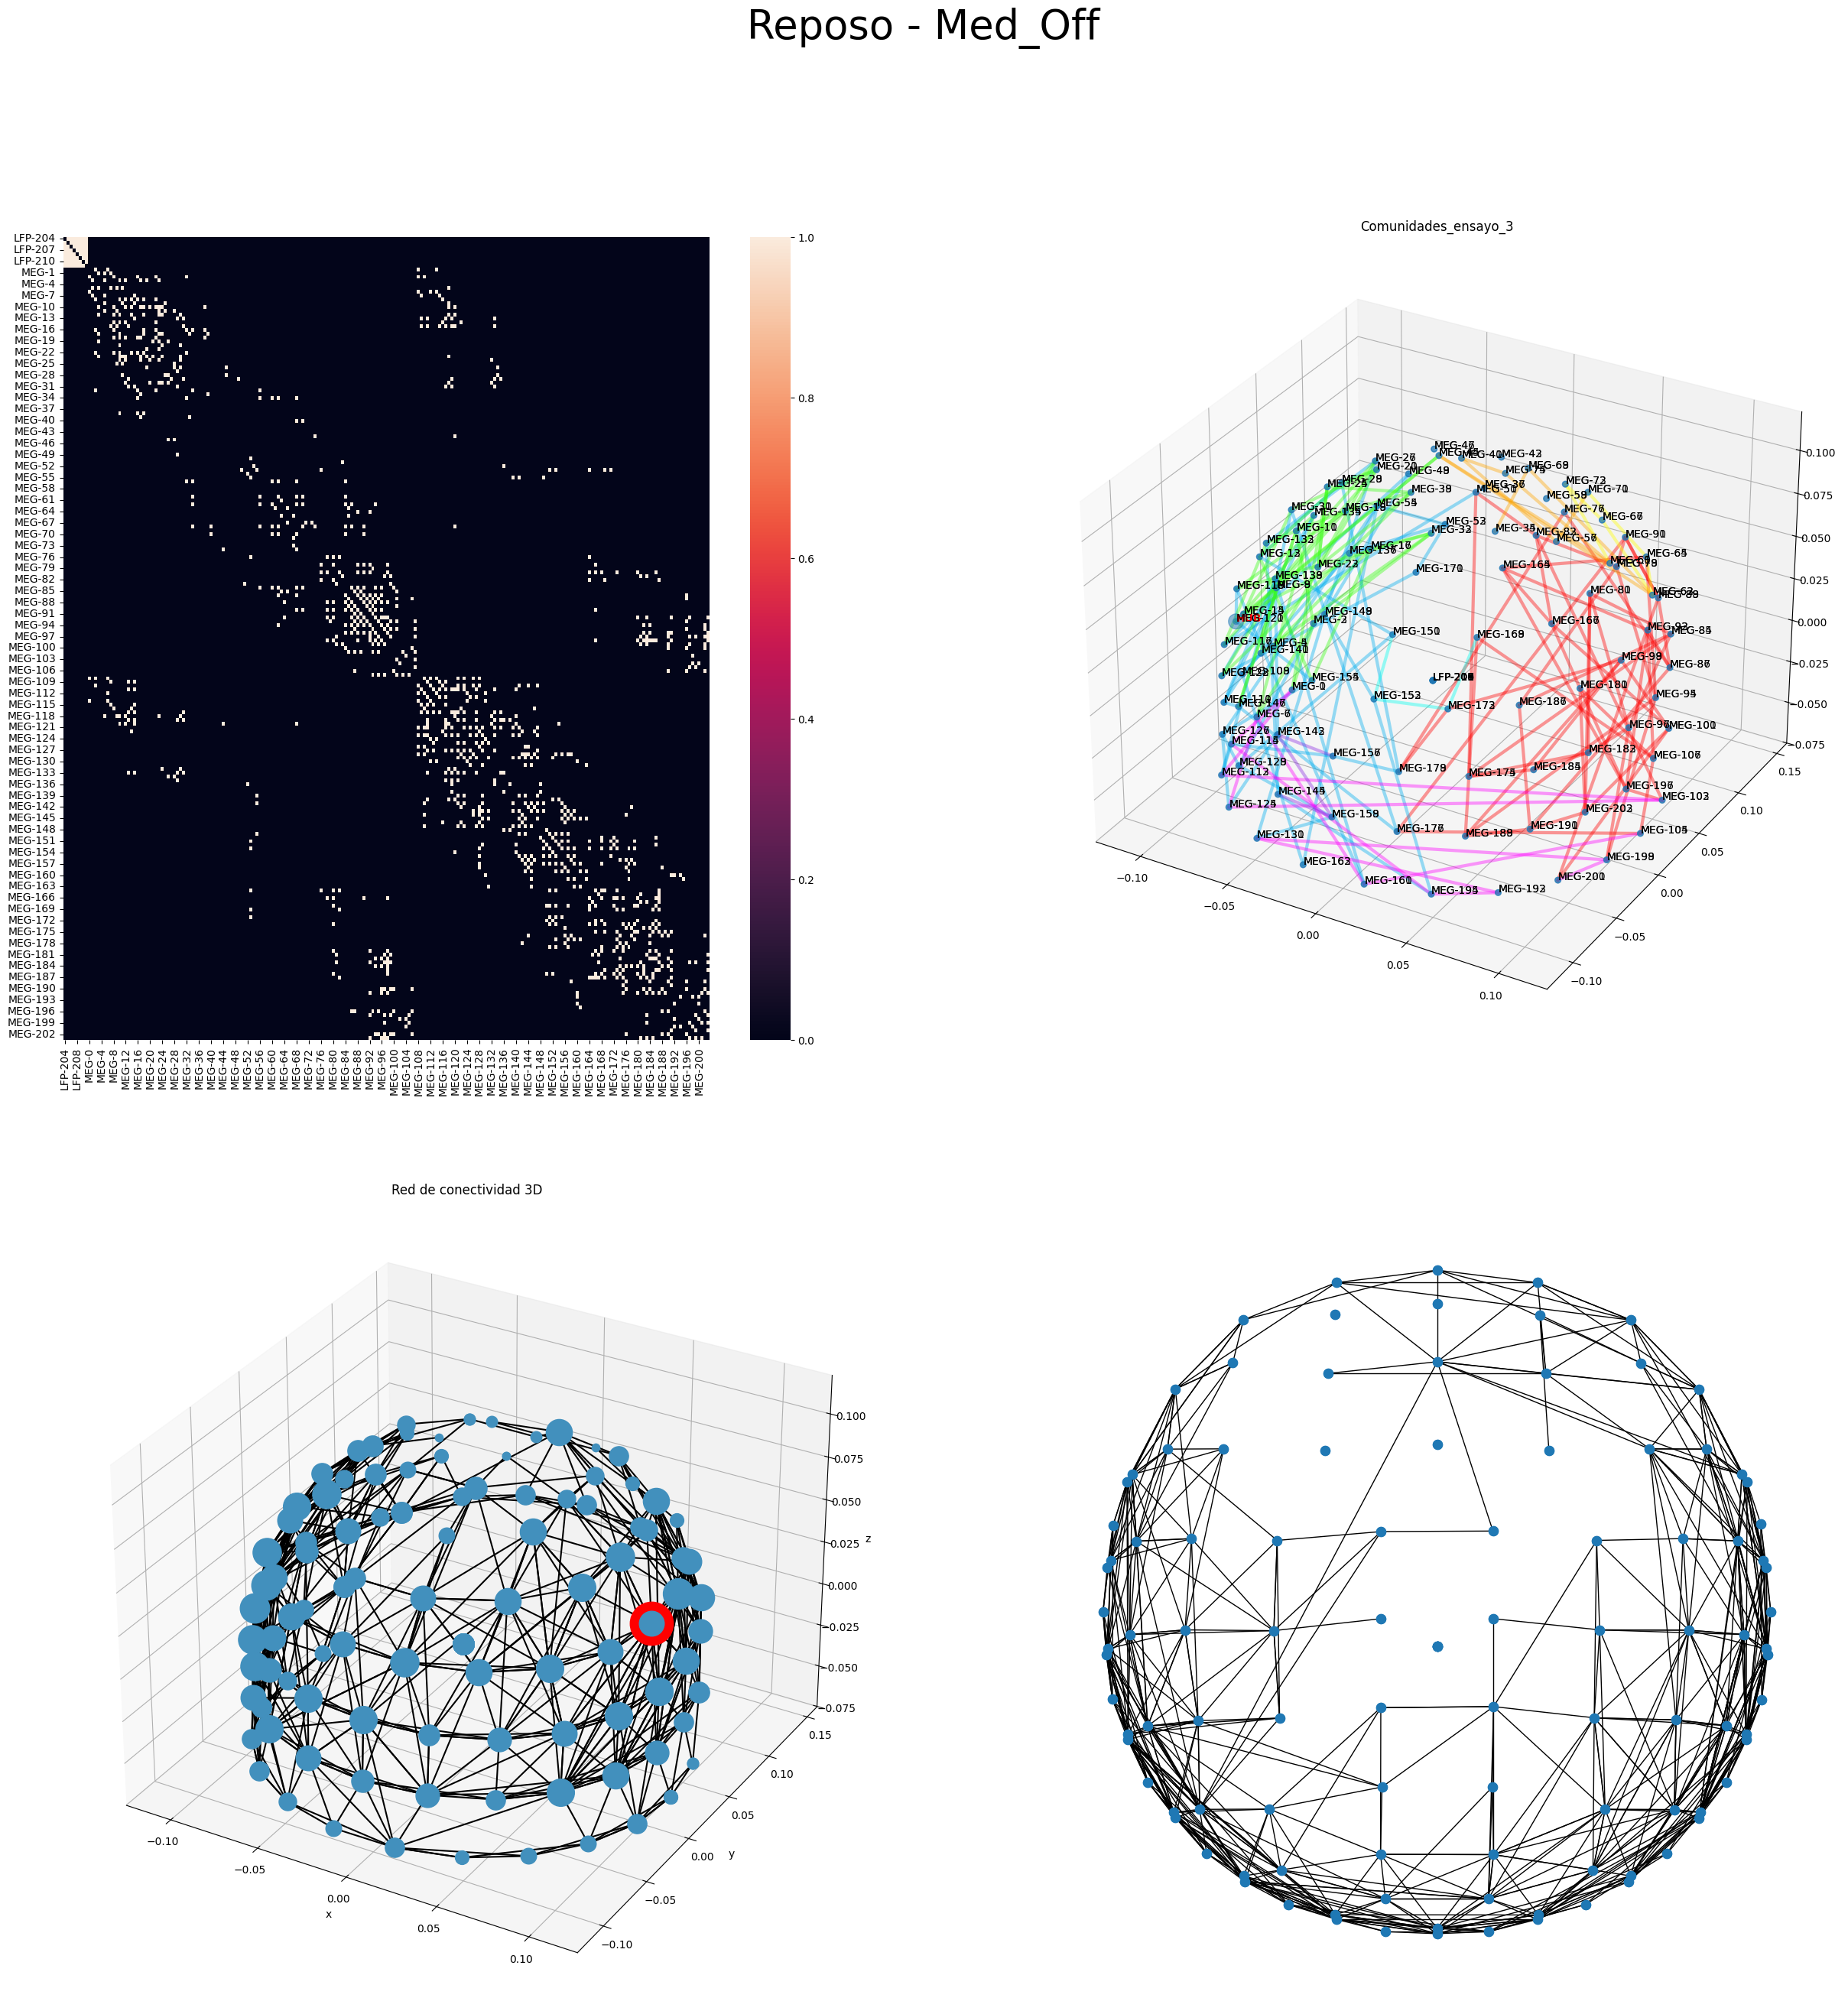

In [320]:
fig = plt.figure(figsize=(30,30))
fig.suptitle('Reposo - Med_Off', fontsize=38)
axes = [fig.add_subplot(2, 2, 1),
        fig.add_subplot(2, 2, 2, projection='3d'),
       fig.add_subplot(2, 2, 3, projection='3d'),
       fig.add_subplot(2, 2, 4)]
hub = betwenness_MOffR[0]
sns.heatmap(democracia_Med_Off_rest, ax = axes[0])
grafcomm(communities_MOffR, hub, coords, axes[1])
graf3dHub(democracia_Med_Off_rest, coords, axes[2])
graf2d(democracia_Med_Off_rest, coords, axes[3])

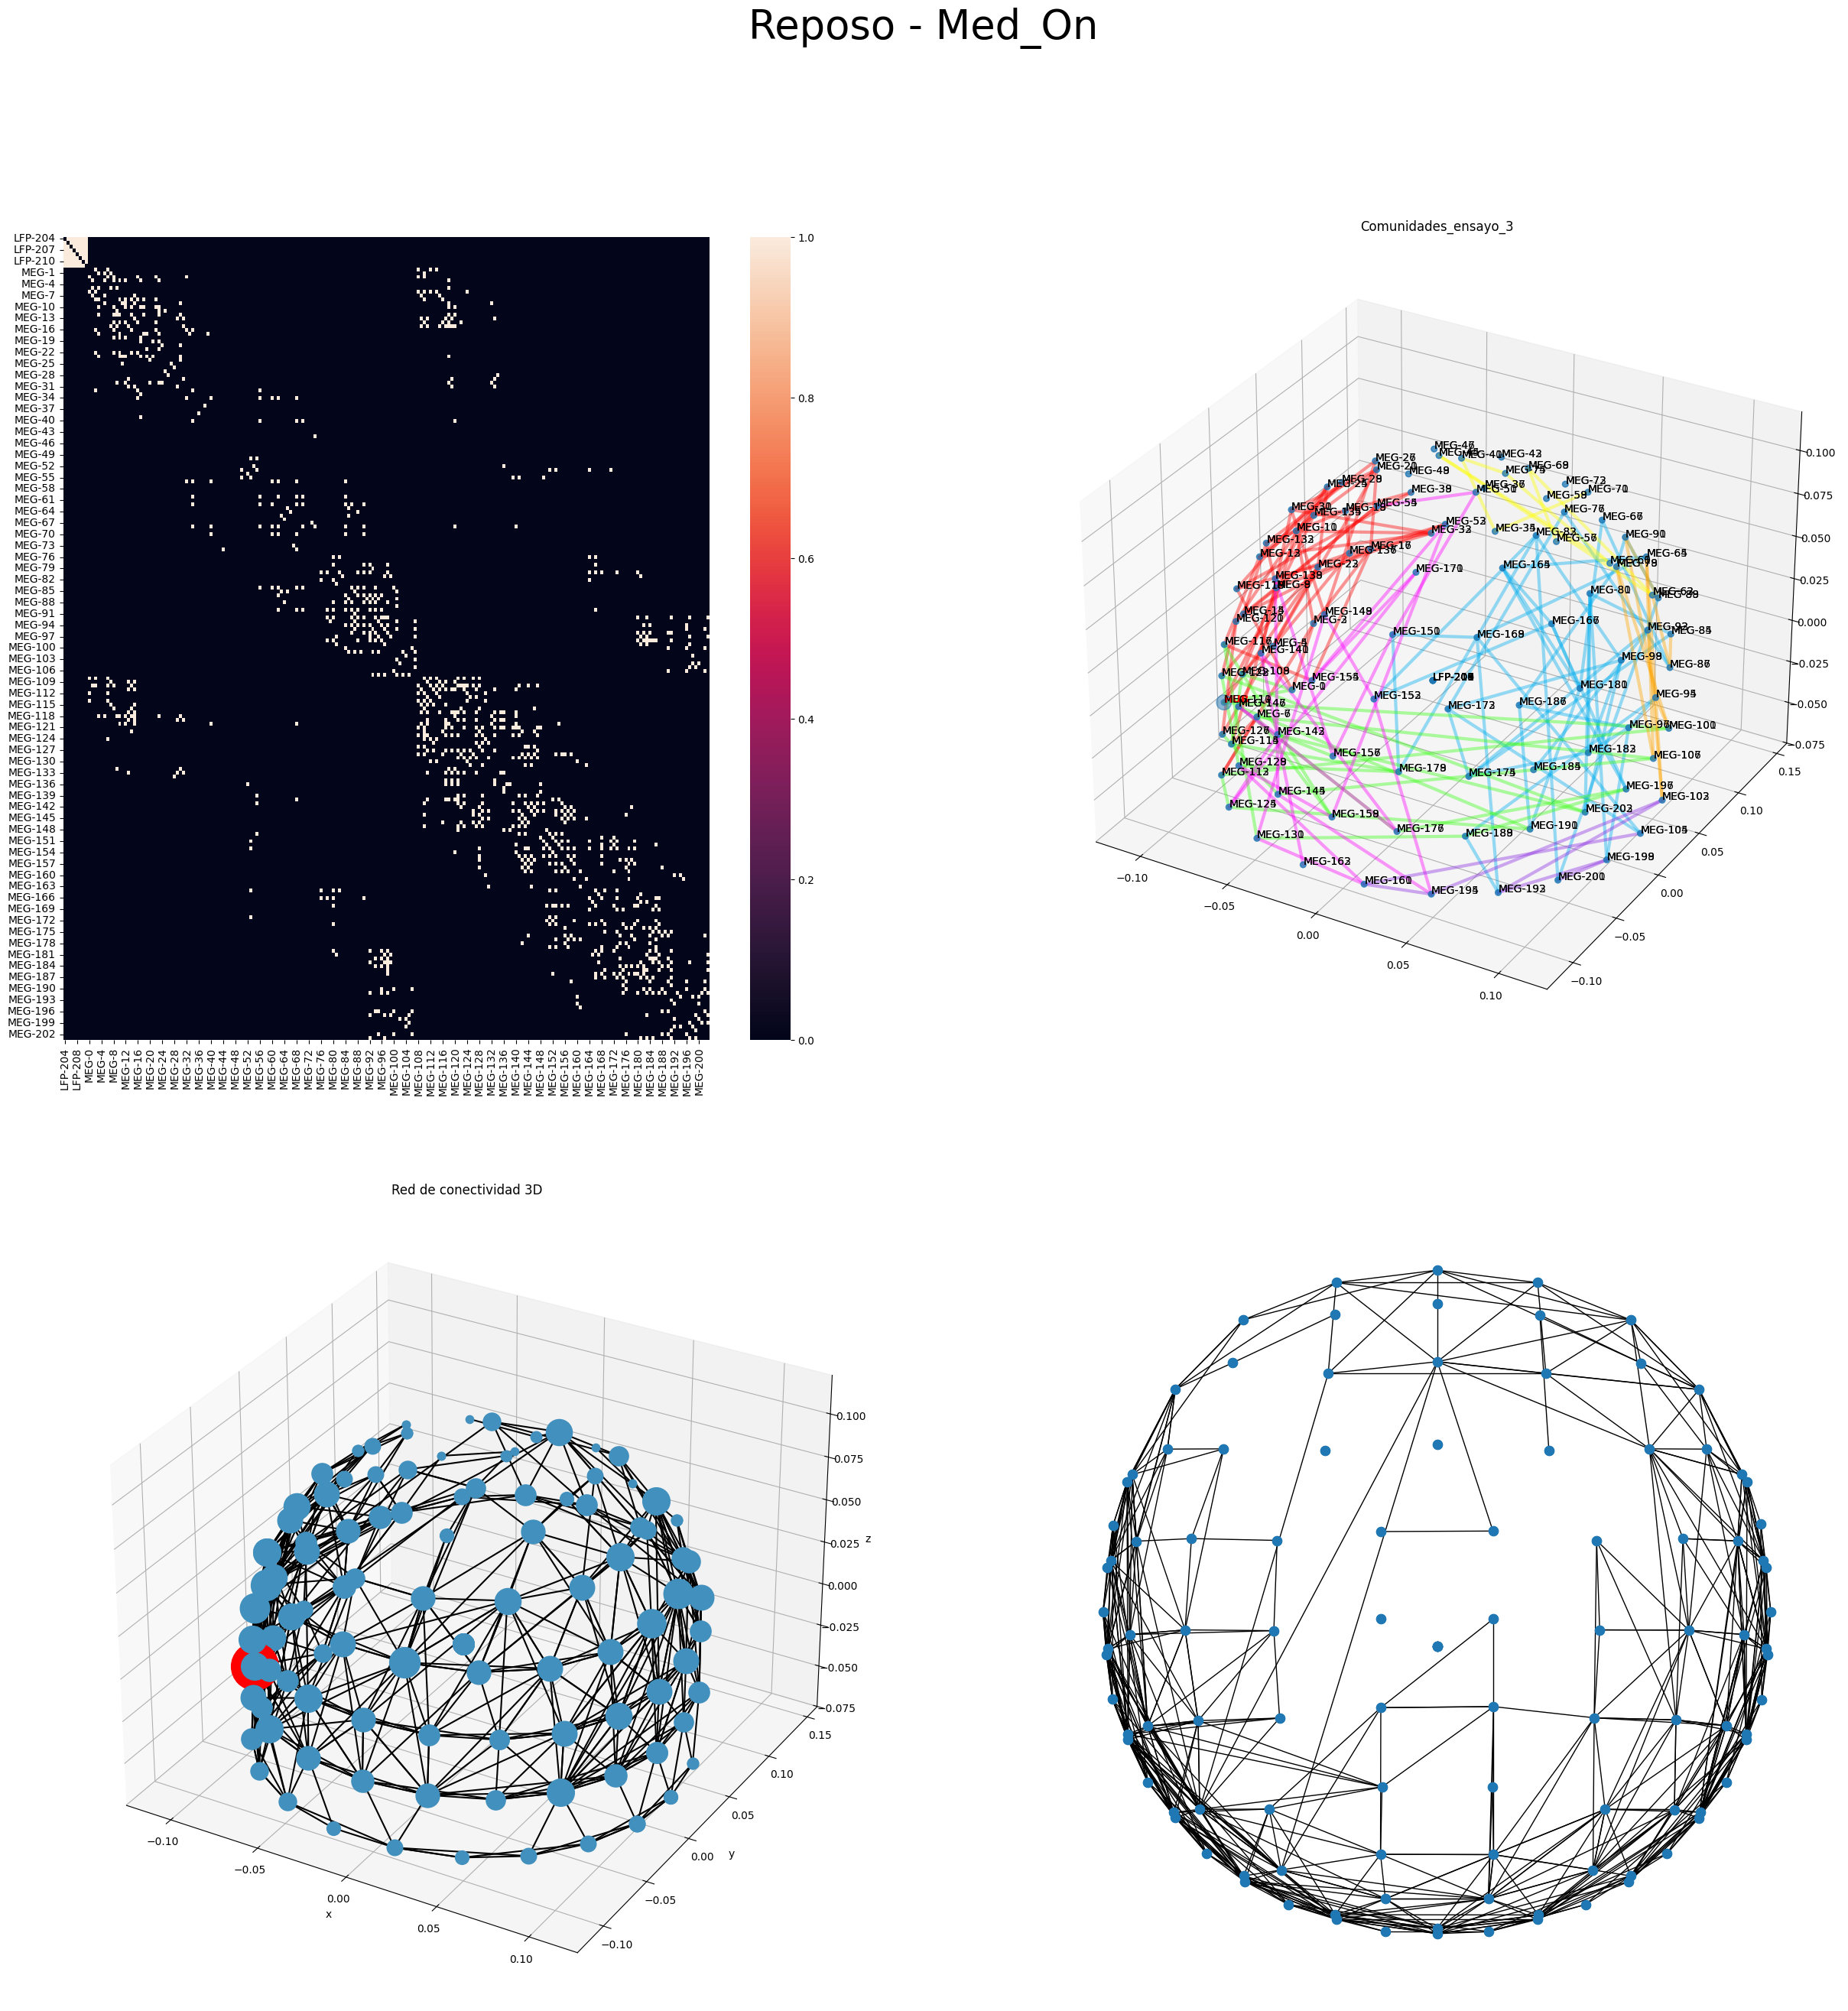

In [324]:
fig = plt.figure(figsize=(30,30))
fig.suptitle('Reposo - Med_On', fontsize=38)
axes = [fig.add_subplot(2, 2, 1),
        fig.add_subplot(2, 2, 2, projection='3d'),
       fig.add_subplot(2, 2, 3, projection='3d'),
       fig.add_subplot(2, 2, 4)]
hub = betwenness_MOnR[0]
sns.heatmap(democracia_Med_On_rest, ax = axes[0])
grafcomm(communities_MOnR, hub, coords, axes[1])
graf3dHub(democracia_Med_On_rest, coords, axes[2])
graf2d(democracia_Med_On_rest, coords, axes[3])

In [357]:
on_ones = democracia_Med_On_rest.values.sum()
on_zeros = democracia_Med_On_rest.size - on_ones
off_ones = democracia_Med_Off_rest.values.sum()
off_zeros = democracia_Med_Off_rest.size - off_ones

tabla = np.array([
    [on_ones,  on_zeros],
    [off_ones, off_zeros]
])

chi = pd.DataFrame(tabla, columns = ['Unos', 'Ceros'],  index = ['Med_On', 'Med_Off'])

chi2, p, dof, expected = stats.chi2_contingency(tabla)
print('Valor p de chi cuadrada:', np.round(p,4))
chi

Valor p de chi cuadrada: 0.0001


Unos    Ceros
Med_On   1170.0  43774.0
Med_Off   988.0  43956.0

KS statistic: 0.0847
p-value: 0.0001


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2339525618.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(vec_off, label='MedOff', shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2339525618.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(vec_on, label='MedOn', shade=True)


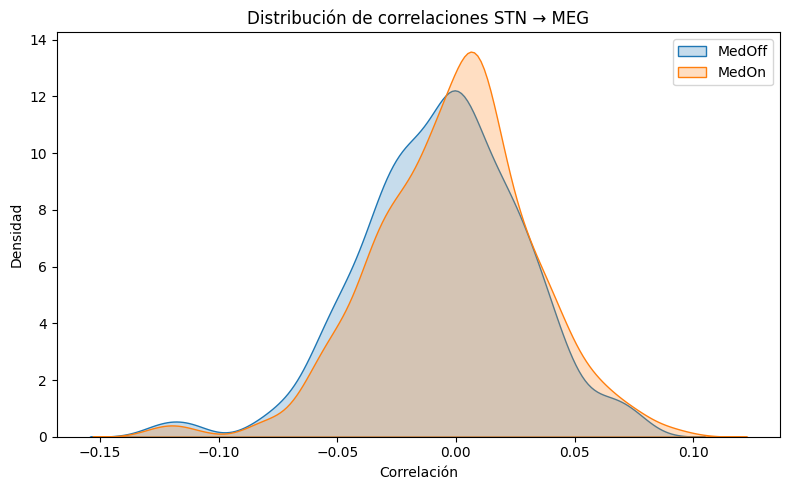

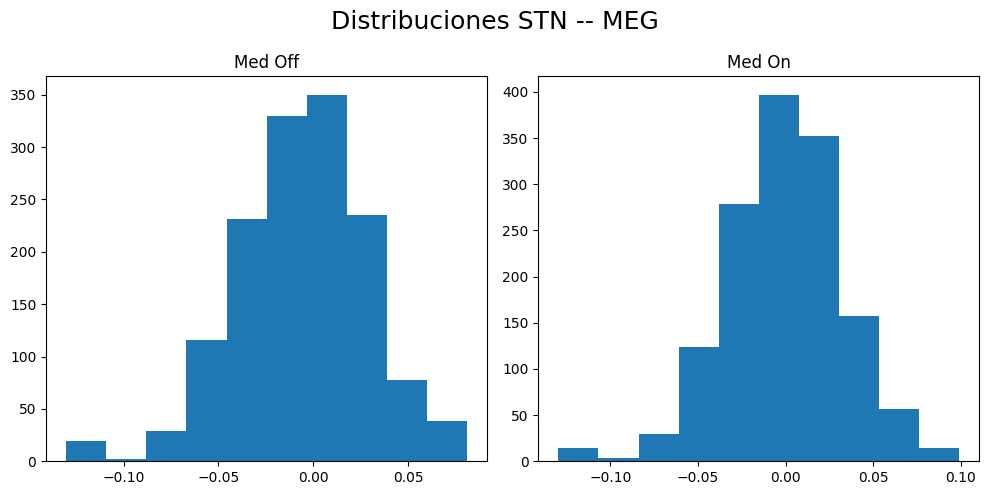

In [384]:
promMOFFR = list(matriz.values for matriz in Med_Off_rest_df)
promMOFFR = np.stack(promMOFFR)
promMOFFR = np.mean(promMOFFR, axis=0)
promMOFFR = pd.DataFrame(data = promMOFFR)
promMOFFR = promMOFFR.iloc[:7,8:]

promMONR = list(matriz.values for matriz in Med_On_rest_df)
promMONR = np.stack(promMONR)
promMONR = np.mean(promMONR, axis=0)
promMONR = pd.DataFrame(data = promMONR)
promMONR = promMONR.iloc[:7,8:]

vec_off = promMOFFR.values.flatten()
vec_on  = promMONR.values.flatten()

from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(vec_off, vec_on)

print("KS statistic:", np.round(ks_stat, 4))
print("p-value:", np.round(p_value, 4))


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.kdeplot(vec_off, label='MedOff', shade=True)
sns.kdeplot(vec_on, label='MedOn', shade=True)
plt.title("Distribución de correlaciones STN → MEG")
plt.xlabel("Correlación")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(10,5))
fig.suptitle('Distribuciones STN -- MEG', fontsize=18)
axes = [
    fig.add_subplot(1, 2, 1),
    fig.add_subplot(1, 2, 2)
]

axes[0].hist(vec_off)
axes[0].set_title('Med Off')

axes[1].hist(vec_on)
axes[1].set_title('Med On')

plt.tight_layout()
plt.show()


In [ ]:
#Se observan métricas muy similares. El coeficiente de clustering, la modularidad, el valor del nodo más central, y la eficiencia
#global y local son muy similares en ambas condiciones. La densidad de conexiones (comparada mediante la preuba chi), aunque tiende a la significancia,
#no es diferente. En ambos grafos se observa una mucho mayor densidad de coenxiones en las zonas temporales (laterales) que en las frontales u 
#occipitales, habiendo la curiosa diferencia de que su nodo más conectado (Hub) se encuetra en lados opuestos. Las comunidades parecen seguir un patrón
#por lóbulos en ambas condciones, con la única diferencia de que hay mayor cantidad en la condición Med-On.


In [ ]:
## Continuación - Entregada el 30 de noviembre

## Comparación Movmiento - Condición

C:\Users\PC\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\139373287.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estadisticos = estadisticos.applymap(lambda x: f"{x:.5f}" if isinstance(x,(float,int)) else x)


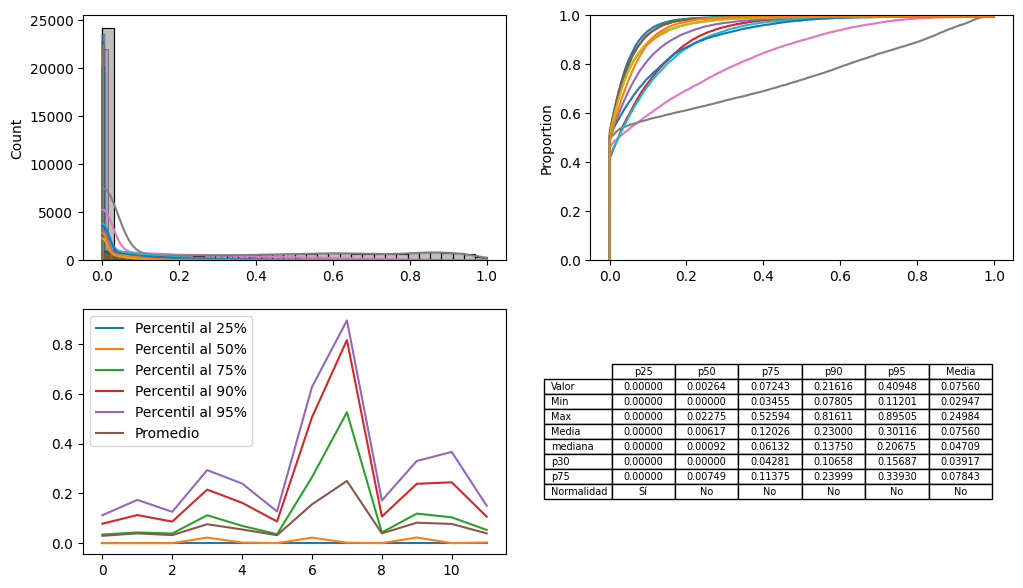

In [376]:
Med_Off_MoveL_pos = mascara(Med_Off_MoveL_df,'positivo')

estadisticos_df2(Med_Off_MoveL_pos) 

<Axes: >

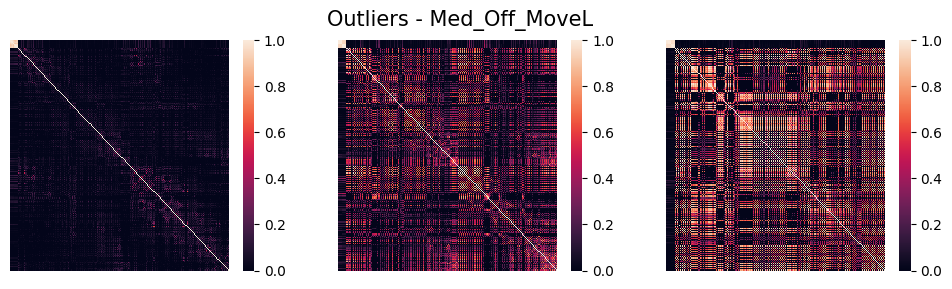

In [377]:
#En este caso se observan dos outliers muy importantes, que parecen ser los sujetos 6 y 7.
fig = plt.figure(figsize=(12,3))
fig.suptitle('Outliers - Med_Off_MoveL', fontsize=15)
axes = [fig.add_subplot(1, 3, 1),
       fig.add_subplot(1, 3, 2),
       fig.add_subplot(1, 3, 3)]
sns.heatmap(Med_Off_MoveL_pos[5], ax = axes[0], xticklabels = False, yticklabels = False)
sns.heatmap(Med_Off_MoveL_pos[6], ax = axes[1], xticklabels = False, yticklabels = False)
sns.heatmap(Med_Off_MoveL_pos[7], ax = axes[2], xticklabels = False, yticklabels = False)
#Esto puede ser atrubuido a un mal registro. El método de umbralización usado desde la fase anterior arregla este problema. Hace que cada matriz
#aporte unicamente su top 5% conexiones más fuertes, sin depender de que tan fuertes sean, y por tanto insensible a los valores más altos mostrados
#por estos dos sujetos. Además que después busca consenso de mayoría simple (51%) de esas conexiones a lo largo de todas las matrices.

<Axes: >

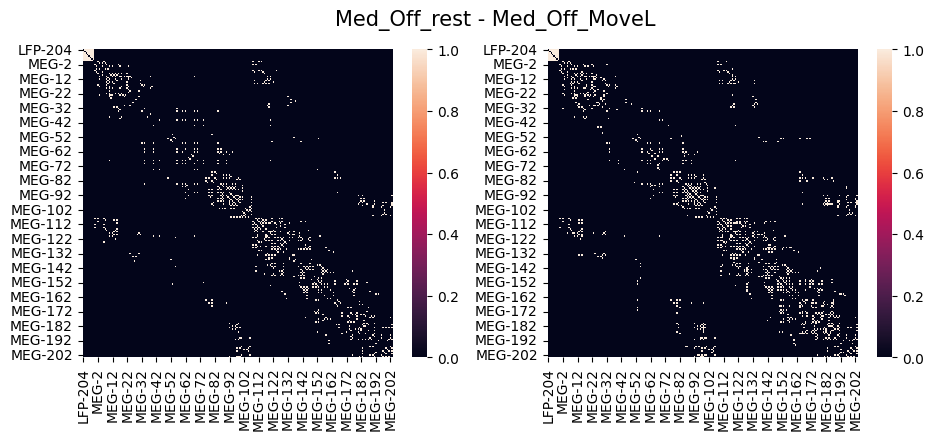

In [304]:
#Se hara el análisis de la matriz positiva y se compara contra la condición Med_Off_rest.
result_dfs_Med_Off_MoveL = mat_por_mat(Med_Off_MoveL_pos,95)
democracia_Med_Off_MoveL = capsula(result_dfs_Med_Off_MoveL,0.9,0.51)
democracia_Med_Off_MoveL = democracia_Med_Off_MoveL - np.eye(212)

fig = plt.figure(figsize=(11,4))
fig.suptitle('Med_Off_rest - Med_Off_MoveL', fontsize=15)
axes = [fig.add_subplot(1, 2, 1),
       fig.add_subplot(1, 2, 2),]
sns.heatmap(democracia_Med_Off_MoveL, ax = axes[0])
sns.heatmap(democracia_Med_Off_rest, ax = axes[1])

Text(0.5, 1.0, 'Med_On MoveL')

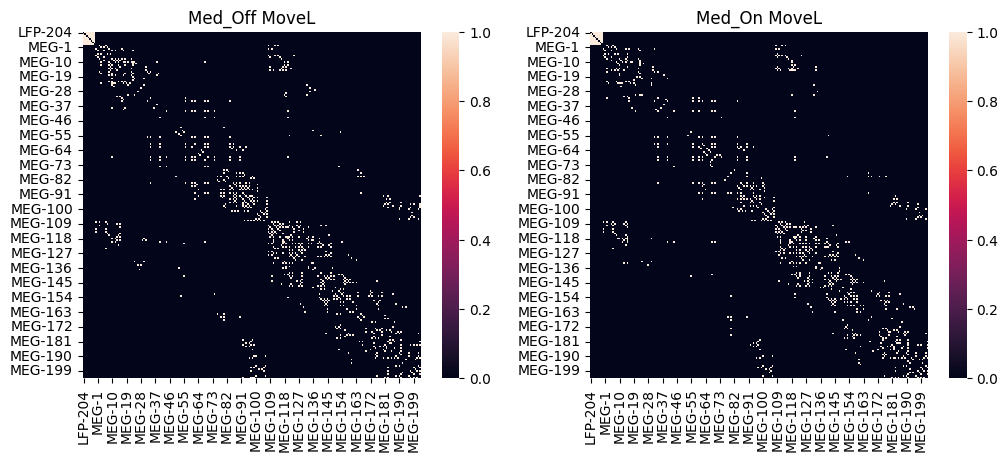

In [375]:
Med_On_MoveL_pos = mascara(Med_On_MoveL_df,'positivo')

result_dfs_Med_Med_Off_MoveL = mat_por_mat(Med_Off_MoveL_pos,95)
democracia_Med_Off_MoveL = capsula(result_dfs_Med_Med_Off_MoveL,0.9,0.51)
result_dfs_Med_Med_On_MoveL = mat_por_mat(Med_On_MoveL_pos,95)
democracia_Med_On_MoveL = capsula(result_dfs_Med_Med_On_MoveL,0.9,0.51)

fig = plt.figure(figsize=(12,4.5))
axes = [fig.add_subplot(1, 2, 1),
            fig.add_subplot(1, 2, 2)]

#Eliminar diagonal
democracia_Med_Off_MoveL = democracia_Med_Off_MoveL - np.eye(212)
democracia_Med_On_MoveL = democracia_Med_On_MoveL - np.eye(212)

sns.heatmap(democracia_Med_Off_MoveL, ax=axes[0])
sns.heatmap(democracia_Med_On_MoveL, ax=axes[1])
axes[0].set_title('Med_Off MoveL')
axes[1].set_title('Med_On MoveL')

In [388]:
#Métricas de MOVEL Med Off
(metricas_Med_Off_MoveL, communities_MoveL, betwenness_MoveL, degree_dict_MoveL) = metricas(democracia_Med_Off_MoveL)
metricas_Med_Off_MoveL.index = ['MedOff Move']
metricas_Med_Off_MoveL

CC Camino más corto      Sigma Comms >1 Comms 1      Mod  \
MedOff Move  0.434912         5.074876  10.597503        8       0  0.65234   

                                      Cent Ef. global Ef. local  \
MedOff Move  (MEG-68, 0.19168968184319388)    0.24864  0.559785   

                                              Top 3 hubs  
MedOff Move  [(MEG-10, 14), (MEG-121, 14), (MEG-92, 13)]

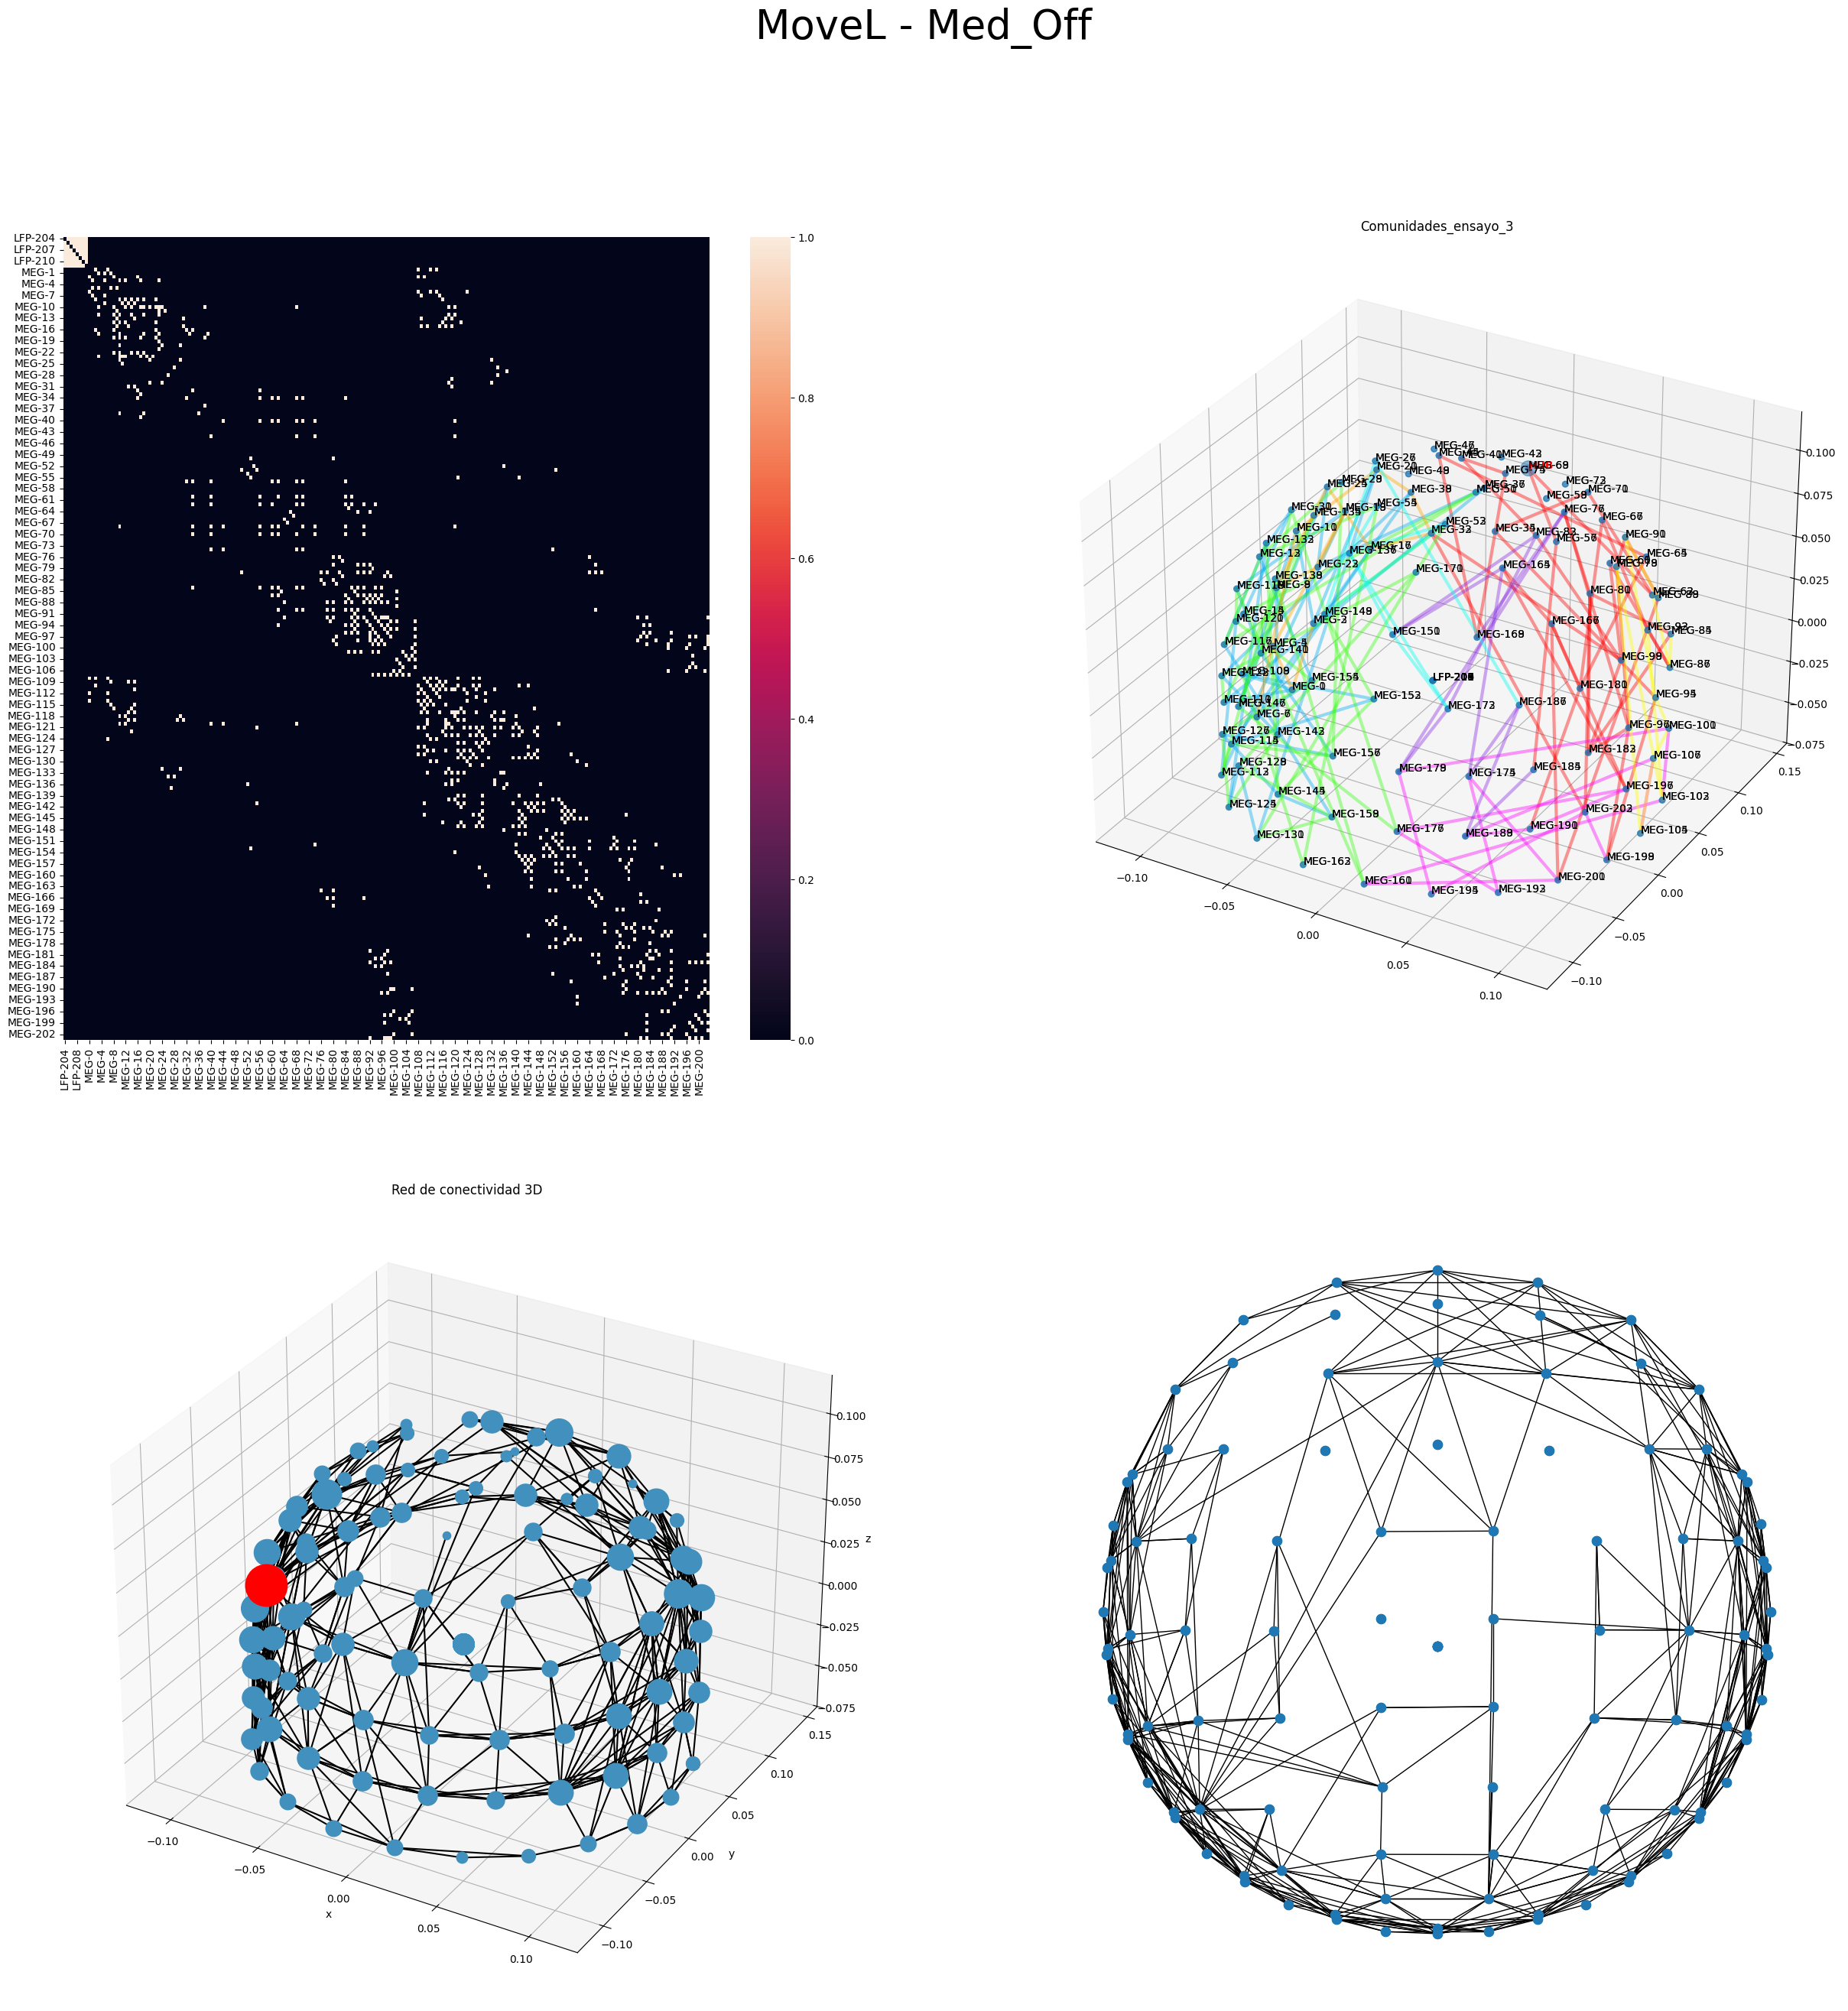

In [325]:
fig = plt.figure(figsize=(30,30))
fig.suptitle('MoveL - Med_Off', fontsize=38)
axes = [fig.add_subplot(2, 2, 1),
        fig.add_subplot(2, 2, 2, projection='3d'),
       fig.add_subplot(2, 2, 3, projection='3d'),
       fig.add_subplot(2, 2, 4)]
hub = betwenness_MoveL[0]
sns.heatmap(democracia_Med_Off_MoveL, ax = axes[0])
grafcomm(communities_MoveL, hub, coords, axes[1])
graf3dHub(democracia_Med_Off_MoveL, coords, axes[2])
graf2d(democracia_Med_Off_MoveL, coords, axes[3])

In [393]:
#Métricas de MOVEL Med On
(metricas_Med_On_MoveL, communities_MoveL_MON, betwenness_MoveL_MON, degree_dict_MoveL_MON) = metricas(democracia_Med_On_MoveL)
metricas_Med_On_MoveL.index = ['MedOn Move']
metricas_Med_On_MoveL

CC Camino más corto     Sigma Comms >1 Comms 1       Mod  \
MedOn Move  0.413765         5.840234  9.169606        9       0  0.680517   

                                      Cent Ef. global Ef. local  \
MedOn Move  (MEG-120, 0.19525157921873124)   0.234198  0.540033   

                                              Top 3 hubs  
MedOn Move  [(MEG-15, 12), (MEG-111, 12), (MEG-120, 12)]

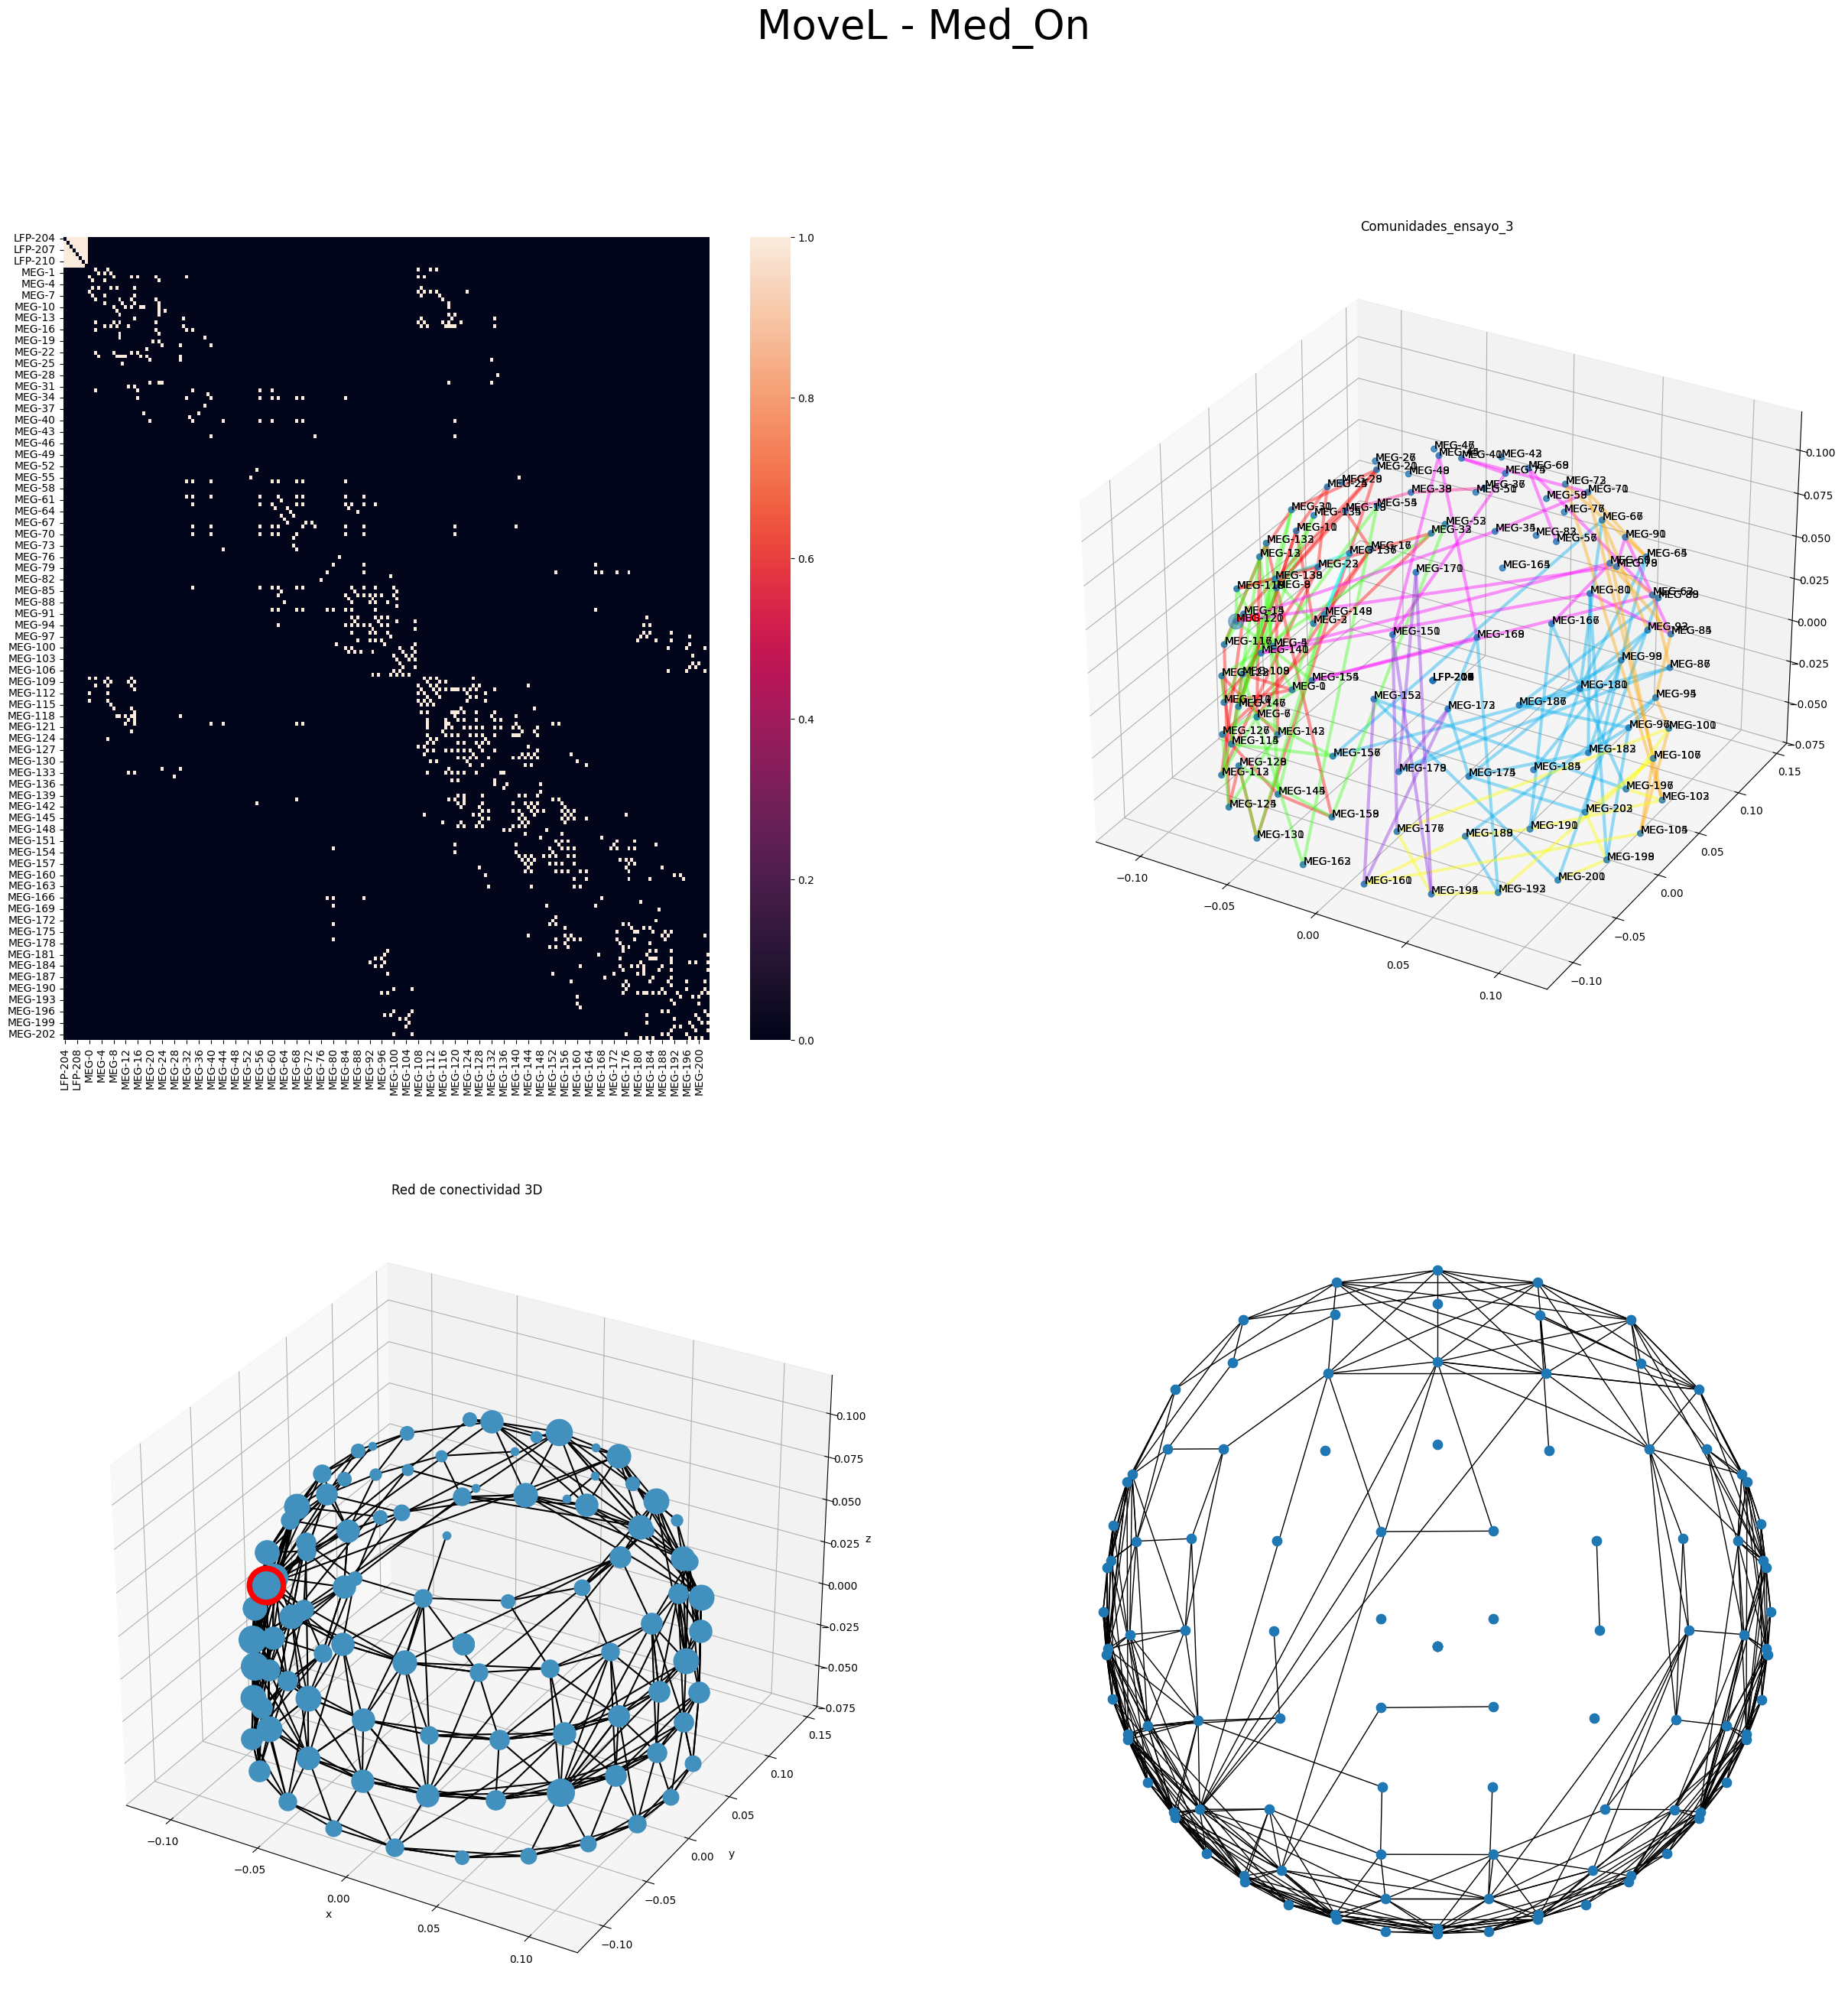

In [380]:
fig = plt.figure(figsize=(30,30))
fig.suptitle('MoveL - Med_On', fontsize=38)
axes = [fig.add_subplot(2, 2, 1),
        fig.add_subplot(2, 2, 2, projection='3d'),
       fig.add_subplot(2, 2, 3, projection='3d'),
       fig.add_subplot(2, 2, 4)]
hub = betwenness_MoveL_MON[0]
sns.heatmap(democracia_Med_On_MoveL, ax = axes[0])
grafcomm(communities_MoveL_MON, hub, coords, axes[1])
graf3dHub(democracia_Med_On_MoveL, coords, axes[2])
graf2d(democracia_Med_On_MoveL, coords, axes[3])

In [382]:
on_ones = democracia_Med_On_MoveL.values.sum()
on_zeros = democracia_Med_On_MoveL.size - on_ones
off_ones = democracia_Med_Off_MoveL.values.sum()
off_zeros = democracia_Med_Off_MoveL.size - off_ones

tabla = np.array([
    [on_ones,  on_zeros],
    [off_ones, off_zeros]
])

chi = pd.DataFrame(tabla, columns = ['Unos', 'Ceros'],  index = ['Med_On', 'Med_Off'])

chi2, p, dof, expected = stats.chi2_contingency(tabla)
print('Valor p de chi cuadrada:', np.round(p,5))
chi

Valor p de chi cuadrada: 0.12104


Unos    Ceros
Med_On   920.0  44024.0
Med_Off  988.0  43956.0

KS statistic: 0.0672
p-value: 0.0031


C:\Users\PC\AppData\Local\Temp\ipykernel_11196\3034948481.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(vec_off, label='MedOff', shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\3034948481.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(vec_on, label='MedOn', shade=True)


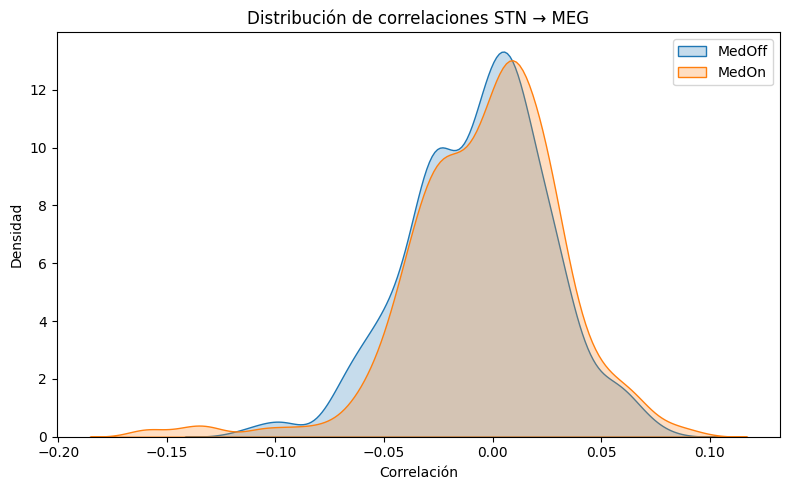

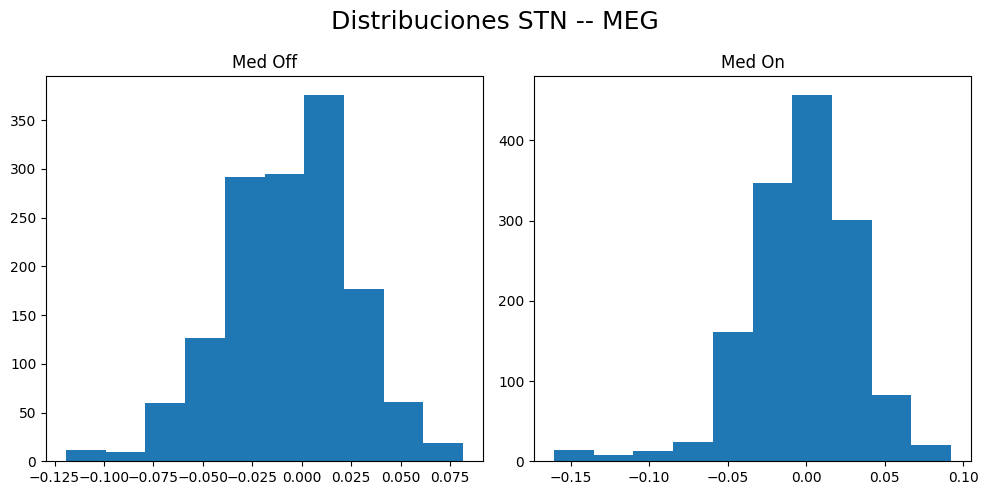

In [385]:
promMOFFM = list(matriz.values for matriz in Med_Off_MoveL_df)
promMOFFM = np.stack(promMOFFM)
promMOFFM = np.mean(promMOFFM, axis=0)
promMOFFM = pd.DataFrame(data = promMOFFM)
promMOFFM = promMOFFM.iloc[:7,8:]

promMONM = list(matriz.values for matriz in Med_On_MoveL_df)
promMONM = np.stack(promMONM)
promMONM = np.mean(promMONM, axis=0)
promMONM = pd.DataFrame(data = promMONM)
promMONM = promMONM.iloc[:7,8:]

vec_off = promMOFFM.values.flatten()
vec_on  = promMONM.values.flatten()

from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(vec_off, vec_on)

print("KS statistic:", np.round(ks_stat, 4))
print("p-value:", np.round(p_value, 4))


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.kdeplot(vec_off, label='MedOff', shade=True)
sns.kdeplot(vec_on, label='MedOn', shade=True)
plt.title("Distribución de correlaciones STN → MEG")
plt.xlabel("Correlación")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(10,5))
fig.suptitle('Distribuciones STN -- MEG', fontsize=18)
axes = [
    fig.add_subplot(1, 2, 1),
    fig.add_subplot(1, 2, 2)
]

axes[0].hist(vec_off)
axes[0].set_title('Med Off')

axes[1].hist(vec_on)
axes[1].set_title('Med On')

plt.tight_layout()
plt.show()
